# Linear model on features extracted from 3 fMRI atlases: Basc197, Craddock, Power 2011




In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

In [3]:
data_train['fmri_select'].value_counts()

1    1007
0     120
Name: fmri_select, dtype: int64

In [4]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.65, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from sklearn.model_selection import StratifiedKFold


def another_evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results



from problem import get_cv


def original_evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

Select features with LR

In [6]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [10]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure

data1_train = data_train.loc[accepted_fmri, :].copy()

In [11]:
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)
x_train1 = np.zeros((len(data1_train), 197 * 196 // 2 ))

for i, v in enumerate(data1_train[['fmri_motions', 'fmri_basc197']].values):
    path_motions, path_fmri_atlas = v
    path_motions = os.path.join(path, path_motions)
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, path_fmri_atlas)
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train1[i, :] = correlation_matrix

In [13]:
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)
x_train2 = np.zeros((len(data1_train), 249 * 248 // 2 ))

for i, v in enumerate(data1_train[['fmri_motions', 'fmri_craddock_scorr_mean']].values):
    path_motions, path_fmri_atlas = v
    path_motions = os.path.join(path, path_motions)
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, path_fmri_atlas)
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train2[i, :] = correlation_matrix

In [14]:
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)
x_train3 = np.zeros((len(data1_train), 34716 ))

for i, v in enumerate(data1_train[['fmri_motions', 'fmri_power_2011']].values):
    path_motions, path_fmri_atlas = v
    path_motions = os.path.join(path, path_motions)
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, path_fmri_atlas)
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train3[i, :] = correlation_matrix

In [17]:
data2_train = data1_train[['participants_sex', 'participants_age', 'target']].copy()

In [18]:
basc197_features = ["basc197_{}".format(i) for i in range(x_train1.shape[1])]
craddock_features = ["craddock_{}".format(i) for i in range(x_train2.shape[1])]
power_features = ["power_{}".format(i) for i in range(x_train3.shape[1])]


data2_train = pd.concat([data2_train, pd.DataFrame(x_train1, index=data2_train.index, columns=basc197_features)], axis=1)
data2_train = pd.concat([data2_train, pd.DataFrame(x_train2, index=data2_train.index, columns=craddock_features)], axis=1)
data2_train = pd.concat([data2_train, pd.DataFrame(x_train3, index=data2_train.index, columns=power_features)], axis=1)


In [19]:
data2_train.columns

Index(['participants_sex', 'participants_age', 'target', 'basc197_0',
       'basc197_1', 'basc197_2', 'basc197_3', 'basc197_4', 'basc197_5',
       'basc197_6',
       ...
       'power_34706', 'power_34707', 'power_34708', 'power_34709',
       'power_34710', 'power_34711', 'power_34712', 'power_34713',
       'power_34714', 'power_34715'],
      dtype='object', length=84901)

In [20]:
top_basc197_features = ["basc197_34", "basc197_54", "basc197_56", "basc197_79", "basc197_85", "basc197_96", "basc197_97", "basc197_104", "basc197_120", "basc197_130", "basc197_161", "basc197_339", "basc197_348", "basc197_372", "basc197_373", "basc197_430", "basc197_447", "basc197_452", "basc197_553", "basc197_555", "basc197_576", "basc197_713", "basc197_727", "basc197_744", "basc197_748", "basc197_765", "basc197_770", "basc197_787", "basc197_788", "basc197_791", "basc197_800", "basc197_806", "basc197_869", "basc197_893", "basc197_910", "basc197_917", "basc197_926", "basc197_948", "basc197_964", "basc197_967", "basc197_968", "basc197_970", "basc197_981", "basc197_989", "basc197_1093", "basc197_1129", "basc197_1135", "basc197_1138", "basc197_1149", "basc197_1161", "basc197_1164", "basc197_1179", "basc197_1224", "basc197_1290", "basc197_1312", "basc197_1321", "basc197_1350", "basc197_1384", "basc197_1402", "basc197_1454", "basc197_1471", "basc197_1482", "basc197_1501", "basc197_1502", "basc197_1516", "basc197_1576", "basc197_1610", "basc197_1623", "basc197_1644", "basc197_1667", "basc197_1752", "basc197_1773", "basc197_1786", "basc197_1810", "basc197_1854", "basc197_1915", "basc197_1930", "basc197_1932", "basc197_1942", "basc197_1945", "basc197_1960", "basc197_1961", "basc197_1970", "basc197_1978", "basc197_2021", "basc197_2024", "basc197_2044", "basc197_2046", "basc197_2050", "basc197_2080", "basc197_2081", "basc197_2090", "basc197_2110", "basc197_2145", "basc197_2153", "basc197_2160", "basc197_2162", "basc197_2163", "basc197_2176", "basc197_2244", "basc197_2254", "basc197_2279", "basc197_2292", "basc197_2305", "basc197_2313", "basc197_2314", "basc197_2323", "basc197_2367", "basc197_2382", "basc197_2418", "basc197_2440", "basc197_2444", "basc197_2445", "basc197_2457", "basc197_2489", "basc197_2505", "basc197_2506", "basc197_2530", "basc197_2534", "basc197_2538", "basc197_2542", "basc197_2554", "basc197_2559", "basc197_2571", "basc197_2573", "basc197_2574", "basc197_2583", "basc197_2619", "basc197_2644", "basc197_2677", "basc197_2716", "basc197_2730", "basc197_2738", "basc197_2742", "basc197_2755", "basc197_2762", "basc197_2787", "basc197_2818", "basc197_2832", "basc197_2838", "basc197_2888", "basc197_2893", "basc197_2894", "basc197_2925", "basc197_2927", "basc197_2934", "basc197_2936", "basc197_2947", "basc197_2959", "basc197_3037", "basc197_3044", "basc197_3047", "basc197_3096", "basc197_3137", "basc197_3167", "basc197_3171", "basc197_3176", "basc197_3193", "basc197_3195", "basc197_3200", "basc197_3206", "basc197_3242", "basc197_3247", "basc197_3265", "basc197_3266", "basc197_3272", "basc197_3281", "basc197_3316", "basc197_3333", "basc197_3376", "basc197_3391", "basc197_3400", "basc197_3401", "basc197_3405", "basc197_3406", "basc197_3420", "basc197_3423", "basc197_3447", "basc197_3482", "basc197_3584", "basc197_3587", "basc197_3594", "basc197_3627", "basc197_3633", "basc197_3675", "basc197_3709", "basc197_3765", "basc197_3804", "basc197_3884", "basc197_3903", "basc197_4018", "basc197_4032", "basc197_4082", "basc197_4257", "basc197_4290", "basc197_4292", "basc197_4294", "basc197_4296", "basc197_4297", "basc197_4302", "basc197_4339", "basc197_4415", "basc197_4416", "basc197_4418", "basc197_4442", "basc197_4446", "basc197_4447", "basc197_4461", "basc197_4599", "basc197_4614", "basc197_4640", "basc197_4663", "basc197_4664", "basc197_4701", "basc197_4718", "basc197_4759", "basc197_4774", "basc197_4797", "basc197_4815", "basc197_4824", "basc197_4828", "basc197_4840", "basc197_4847", "basc197_4869", "basc197_4875", "basc197_4922", "basc197_4931", "basc197_4936", "basc197_4984", "basc197_5015", "basc197_5065", "basc197_5112", "basc197_5118", "basc197_5284", "basc197_5297", "basc197_5340", "basc197_5351", "basc197_5438", "basc197_5449", "basc197_5450", "basc197_5467", "basc197_5468", "basc197_5480", "basc197_5485", "basc197_5493", "basc197_5502", "basc197_5505", "basc197_5513", "basc197_5524", "basc197_5556", "basc197_5559", "basc197_5564", "basc197_5606", "basc197_5649", "basc197_5706", "basc197_5755", "basc197_5790", "basc197_5791", "basc197_5796", "basc197_5845", "basc197_5861", "basc197_5872", "basc197_5882", "basc197_5955", "basc197_5959", "basc197_5978", "basc197_6007", "basc197_6050", "basc197_6055", "basc197_6067", "basc197_6112", "basc197_6119", "basc197_6180", "basc197_6186", "basc197_6204", "basc197_6218", "basc197_6230", "basc197_6243", "basc197_6248", "basc197_6343", "basc197_6357", "basc197_6362", "basc197_6377", "basc197_6388", "basc197_6415", "basc197_6458", "basc197_6497", "basc197_6701", "basc197_6708", "basc197_6710", "basc197_6750", "basc197_6758", "basc197_6766", "basc197_6777", "basc197_6862", "basc197_6874", "basc197_6897", "basc197_6906", "basc197_6909", "basc197_6915", "basc197_6926", "basc197_6947", "basc197_6964", "basc197_6994", "basc197_7004", "basc197_7010", "basc197_7016", "basc197_7042", "basc197_7052", "basc197_7092", "basc197_7155", "basc197_7186", "basc197_7215", "basc197_7282", "basc197_7311", "basc197_7334", "basc197_7350", "basc197_7366", "basc197_7369", "basc197_7479", "basc197_7498", "basc197_7514", "basc197_7551", "basc197_7580", "basc197_7640", "basc197_7653", "basc197_7670", "basc197_7744", "basc197_7771", "basc197_7807", "basc197_7818", "basc197_7828", "basc197_7874", "basc197_7914", "basc197_7935", "basc197_7974", "basc197_7975", "basc197_8042", "basc197_8068", "basc197_8069", "basc197_8073", "basc197_8079", "basc197_8113", "basc197_8133", "basc197_8135", "basc197_8140", "basc197_8160", "basc197_8172", "basc197_8186", "basc197_8188", "basc197_8196", "basc197_8235", "basc197_8236", "basc197_8246", "basc197_8270", "basc197_8294", "basc197_8302", "basc197_8317", "basc197_8331", "basc197_8350", "basc197_8357", "basc197_8393", "basc197_8398", "basc197_8418", "basc197_8453", "basc197_8498", "basc197_8545", "basc197_8549", "basc197_8585", "basc197_8587", "basc197_8620", "basc197_8645", "basc197_8652", "basc197_8670", "basc197_8712", "basc197_8723", "basc197_8740", "basc197_8786", "basc197_8819", "basc197_8826", "basc197_8837", "basc197_8840", "basc197_8885", "basc197_8902", "basc197_8951", "basc197_8963", "basc197_8997", "basc197_9047", "basc197_9071", "basc197_9100", "basc197_9105", "basc197_9116", "basc197_9138", "basc197_9173", "basc197_9177", "basc197_9192", "basc197_9197", "basc197_9211", "basc197_9216", "basc197_9226", "basc197_9251", "basc197_9255", "basc197_9273", "basc197_9383", "basc197_9595", "basc197_9606", "basc197_9607", "basc197_9620", "basc197_9640", "basc197_9643", "basc197_9653", "basc197_9659", "basc197_9701", "basc197_9733", "basc197_9745", "basc197_9748", "basc197_9791", "basc197_9796", "basc197_9843", "basc197_9854", "basc197_9877", "basc197_9878", "basc197_9884", "basc197_9895", "basc197_9900", "basc197_9904", "basc197_9919", "basc197_9927", "basc197_9969", "basc197_10044", "basc197_10049", "basc197_10099", "basc197_10100", "basc197_10107", "basc197_10113", "basc197_10125", "basc197_10153", "basc197_10170", "basc197_10193", "basc197_10224", "basc197_10264", "basc197_10282", "basc197_10294", "basc197_10331", "basc197_10351", "basc197_10362", "basc197_10374", "basc197_10424", "basc197_10444", "basc197_10457", "basc197_10480", "basc197_10507", "basc197_10509", "basc197_10513", "basc197_10547", "basc197_10553", "basc197_10585", "basc197_10593", "basc197_10610", "basc197_10627", "basc197_10652", "basc197_10666", "basc197_10730", "basc197_10752", "basc197_10774", "basc197_10788", "basc197_10819", "basc197_10855", "basc197_10877", "basc197_10883", "basc197_10885", "basc197_10886", "basc197_10897", "basc197_10903", "basc197_10908", "basc197_10909", "basc197_10938", "basc197_10978", "basc197_11027", "basc197_11036", "basc197_11037", "basc197_11065", "basc197_11078", "basc197_11086", "basc197_11104", "basc197_11124", "basc197_11165", "basc197_11169", "basc197_11325", "basc197_11333", "basc197_11339", "basc197_11492", "basc197_11528", "basc197_11567", "basc197_11592", "basc197_11702", "basc197_11737", "basc197_11749", "basc197_11797", "basc197_11845", "basc197_11851", "basc197_11868", "basc197_11899", "basc197_11952", "basc197_11965", "basc197_12001", "basc197_12021", "basc197_12037", "basc197_12071", "basc197_12104", "basc197_12130", "basc197_12133", "basc197_12179", "basc197_12180", "basc197_12231", "basc197_12260", "basc197_12278", "basc197_12298", "basc197_12362", "basc197_12363", "basc197_12386", "basc197_12389", "basc197_12399", "basc197_12404", "basc197_12405", "basc197_12413", "basc197_12418", "basc197_12432", "basc197_12478", "basc197_12479", "basc197_12489", "basc197_12498", "basc197_12579", "basc197_12584", "basc197_12585", "basc197_12596", "basc197_12612", "basc197_12641", "basc197_12662", "basc197_12681", "basc197_12687", "basc197_12688", "basc197_12690", "basc197_12700", "basc197_12829", "basc197_12861", "basc197_12906", "basc197_12920", "basc197_12959", "basc197_12980", "basc197_13035", "basc197_13036", "basc197_13058", "basc197_13111", "basc197_13113", "basc197_13196", "basc197_13197", "basc197_13203", "basc197_13220", "basc197_13309", "basc197_13336", "basc197_13343", "basc197_13355", "basc197_13367", "basc197_13376", "basc197_13396", "basc197_13415", "basc197_13450", "basc197_13493", "basc197_13557", "basc197_13558", "basc197_13594", "basc197_13607", "basc197_13637", "basc197_13729", "basc197_13741", "basc197_13774", "basc197_13800", "basc197_13809", "basc197_13930", "basc197_13935", "basc197_13962", "basc197_13969", "basc197_13981", "basc197_14021", "basc197_14029", "basc197_14043", "basc197_14057", "basc197_14067", "basc197_14069", "basc197_14079", "basc197_14088", "basc197_14102", "basc197_14121", "basc197_14141", "basc197_14187", "basc197_14194", "basc197_14214", "basc197_14216", "basc197_14217", "basc197_14231", "basc197_14240", "basc197_14278", "basc197_14295", "basc197_14306", "basc197_14321", "basc197_14322", "basc197_14357", "basc197_14363", "basc197_14399", "basc197_14413", "basc197_14427", "basc197_14472", "basc197_14518", "basc197_14525", "basc197_14540", "basc197_14576", "basc197_14586", "basc197_14609", "basc197_14663", "basc197_14688", "basc197_14708", "basc197_14800", "basc197_14810", "basc197_14811", "basc197_14821", "basc197_14840", "basc197_14883", "basc197_14912", "basc197_14938", "basc197_14942", "basc197_14944", "basc197_14957", "basc197_14978", "basc197_14983", "basc197_15039", "basc197_15042", "basc197_15048", "basc197_15049", "basc197_15061", "basc197_15078", "basc197_15086", "basc197_15133", "basc197_15178", "basc197_15217", "basc197_15249", "basc197_15277", "basc197_15402", "basc197_15403", "basc197_15410", "basc197_15415", "basc197_15439", "basc197_15443", "basc197_15475", "basc197_15494", "basc197_15510", "basc197_15512", "basc197_15587", "basc197_15591", "basc197_15597", "basc197_15605", "basc197_15638", "basc197_15644", "basc197_15669", "basc197_15708", "basc197_15735", "basc197_15744", "basc197_15787", "basc197_15840", "basc197_15881", "basc197_16037", "basc197_16046", "basc197_16057", "basc197_16086", "basc197_16111", "basc197_16115", "basc197_16153", "basc197_16198", "basc197_16205", "basc197_16263", "basc197_16270", "basc197_16313", "basc197_16323", "basc197_16330", "basc197_16357", "basc197_16389", "basc197_16420", "basc197_16421", "basc197_16426", "basc197_16474", "basc197_16486", "basc197_16499", "basc197_16649", "basc197_16750", "basc197_16759", "basc197_16854", "basc197_16896", "basc197_16907", "basc197_16934", "basc197_16939", "basc197_16945", "basc197_16964", "basc197_16971", "basc197_16994", "basc197_17007", "basc197_17072", "basc197_17082", "basc197_17084", "basc197_17116", "basc197_17162", "basc197_17200", "basc197_17215", "basc197_17218", "basc197_17229", "basc197_17232", "basc197_17244", "basc197_17245", "basc197_17253", "basc197_17359", "basc197_17380", "basc197_17403", "basc197_17410", "basc197_17431", "basc197_17493", "basc197_17495", "basc197_17532", "basc197_17533", "basc197_17567", "basc197_17571", "basc197_17572", "basc197_17579", "basc197_17622", "basc197_17739", "basc197_17783", "basc197_17806", "basc197_17812", "basc197_17859", "basc197_17862", "basc197_17953", "basc197_17957", "basc197_17969", "basc197_17975", "basc197_17981", "basc197_17987", "basc197_17999", "basc197_18018", "basc197_18049", "basc197_18158", "basc197_18193", "basc197_18212", "basc197_18235", "basc197_18252", "basc197_18266", "basc197_18284", "basc197_18297", "basc197_18322", "basc197_18338", "basc197_18400", "basc197_18583", "basc197_18593", "basc197_18596", "basc197_18599", "basc197_18697", "basc197_18698", "basc197_18735", "basc197_18751", "basc197_18753", "basc197_18795", "basc197_18803", "basc197_18808", "basc197_18819", "basc197_18829", "basc197_18864", "basc197_18877", "basc197_18883", "basc197_18884", "basc197_18887", "basc197_18890", "basc197_18899", "basc197_18905", "basc197_18914", "basc197_18970", "basc197_18980", "basc197_19093", "basc197_19097", "basc197_19116", "basc197_19220", "basc197_19232", "basc197_19259", "basc197_19263", "basc197_19270", "basc197_0", "basc197_21", "basc197_28", "basc197_32", "basc197_103", "basc197_137", "basc197_163", "basc197_175", "basc197_190", "basc197_210", "basc197_245", "basc197_282", "basc197_290", "basc197_303", "basc197_336", "basc197_362", "basc197_381", "basc197_397", "basc197_427", "basc197_434", "basc197_439", "basc197_463", "basc197_508", "basc197_526", "basc197_532", "basc197_543", "basc197_638", "basc197_654", "basc197_694", "basc197_696", "basc197_698", "basc197_703", "basc197_709", "basc197_786", "basc197_828", "basc197_845", "basc197_864", "basc197_865", "basc197_884", "basc197_897", "basc197_902", "basc197_1032", "basc197_1140", "basc197_1145", "basc197_1158", "basc197_1225", "basc197_1227", "basc197_1232", "basc197_1239", "basc197_1257", "basc197_1276", "basc197_1282", "basc197_1284", "basc197_1288", "basc197_1295", "basc197_1310", "basc197_1313", "basc197_1315", "basc197_1330", "basc197_1347", "basc197_1353", "basc197_1365", "basc197_1378", "basc197_1429", "basc197_1430", "basc197_1448", "basc197_1460", "basc197_1461", "basc197_1507", "basc197_1563", "basc197_1596", "basc197_1724", "basc197_1755", "basc197_1783", "basc197_1792", "basc197_1800", "basc197_1821", "basc197_1858", "basc197_2030", "basc197_2033", "basc197_2037", "basc197_2048", "basc197_2086", "basc197_2165", "basc197_2185", "basc197_2210", "basc197_2213", "basc197_2243", "basc197_2247", "basc197_2252", "basc197_2267", "basc197_2278", "basc197_2397", "basc197_2405", "basc197_2429", "basc197_2447", "basc197_2500", "basc197_2509", "basc197_2514", "basc197_2546", "basc197_2575", "basc197_2610", "basc197_2668", "basc197_2706", "basc197_2739", "basc197_2745", "basc197_2752", "basc197_2778", "basc197_2790", "basc197_2804", "basc197_2808", "basc197_2816", "basc197_2880", "basc197_2977", "basc197_2991", "basc197_2992", "basc197_3025", "basc197_3038", "basc197_3172", "basc197_3177", "basc197_3230", "basc197_3262", "basc197_3296", "basc197_3320", "basc197_3331", "basc197_3357", "basc197_3364", "basc197_3384", "basc197_3408", "basc197_3414", "basc197_3438", "basc197_3459", "basc197_3463", "basc197_3473", "basc197_3610", "basc197_3669", "basc197_3691", "basc197_3733", "basc197_3736", "basc197_3748", "basc197_3749", "basc197_3750", "basc197_3766", "basc197_3800", "basc197_3816", "basc197_3883", "basc197_3900", "basc197_3923", "basc197_3936", "basc197_3937", "basc197_3941", "basc197_3958", "basc197_3969", "basc197_3987", "basc197_4002", "basc197_4005", "basc197_4006", "basc197_4094", "basc197_4165", "basc197_4191", "basc197_4286", "basc197_4303", "basc197_4319", "basc197_4345", "basc197_4361", "basc197_4365", "basc197_4404", "basc197_4435", "basc197_4493", "basc197_4543", "basc197_4557", "basc197_4558", "basc197_4581", "basc197_4622", "basc197_4647", "basc197_4653", "basc197_4727", "basc197_4732", "basc197_4744", "basc197_4753", "basc197_4767", "basc197_4792", "basc197_4804", "basc197_4842", "basc197_4953", "basc197_4994", "basc197_5002", "basc197_5119", "basc197_5131", "basc197_5155", "basc197_5165", "basc197_5179", "basc197_5183", "basc197_5187", "basc197_5248", "basc197_5264", "basc197_5289", "basc197_5309", "basc197_5313", "basc197_5331", "basc197_5342", "basc197_5360", "basc197_5384", "basc197_5411", "basc197_5428", "basc197_5436", "basc197_5442", "basc197_5474", "basc197_5492", "basc197_5536", "basc197_5540", "basc197_5609", "basc197_5648", "basc197_5658", "basc197_5782", "basc197_5837", "basc197_5884", "basc197_5886", "basc197_5900", "basc197_5941", "basc197_5953", "basc197_5969", "basc197_5994", "basc197_5998", "basc197_6016", "basc197_6172", "basc197_6176", "basc197_6215", "basc197_6219", "basc197_6568", "basc197_6595", "basc197_6623", "basc197_6667", "basc197_6677", "basc197_6698", "basc197_6702", "basc197_6720", "basc197_6790", "basc197_6801", "basc197_6802", "basc197_6832", "basc197_6853", "basc197_6871", "basc197_6896", "basc197_6908", "basc197_6939", "basc197_7023", "basc197_7060", "basc197_7073", "basc197_7085", "basc197_7182", "basc197_7228", "basc197_7273", "basc197_7274", "basc197_7275", "basc197_7277", "basc197_7294", "basc197_7308", "basc197_7309", "basc197_7314", "basc197_7321", "basc197_7323", "basc197_7332", "basc197_7343", "basc197_7367", "basc197_7388", "basc197_7390", "basc197_7398", "basc197_7425", "basc197_7456", "basc197_7464", "basc197_7491", "basc197_7495", "basc197_7522", "basc197_7647", "basc197_7654", "basc197_7666", "basc197_7708", "basc197_7713", "basc197_7748", "basc197_7866", "basc197_7885", "basc197_7897", "basc197_7898", "basc197_7899", "basc197_7956", "basc197_7978", "basc197_7986", "basc197_7995", "basc197_7996", "basc197_7999", "basc197_8008", "basc197_8029", "basc197_8044", "basc197_8045", "basc197_8112", "basc197_8263", "basc197_8264", "basc197_8265", "basc197_8276", "basc197_8281", "basc197_8283", "basc197_8289", "basc197_8323", "basc197_8367", "basc197_8383", "basc197_8423", "basc197_8441", "basc197_8449", "basc197_8478", "basc197_8494", "basc197_8496", "basc197_8676", "basc197_8687", "basc197_8698", "basc197_8743", "basc197_8751", "basc197_8802", "basc197_8924", "basc197_8935", "basc197_8940", "basc197_8944", "basc197_9202", "basc197_9204", "basc197_9231", "basc197_9241", "basc197_9245", "basc197_9254", "basc197_9268", "basc197_9275", "basc197_9283", "basc197_9308", "basc197_9360", "basc197_9407", "basc197_9424", "basc197_9443", "basc197_9505", "basc197_9512", "basc197_9573", "basc197_9604", "basc197_9625", "basc197_9629", "basc197_9644", "basc197_9661", "basc197_9663", "basc197_9668", "basc197_9679", "basc197_9711", "basc197_9727", "basc197_9728", "basc197_9731", "basc197_9757", "basc197_9763", "basc197_9789", "basc197_9842", "basc197_9857", "basc197_9876", "basc197_9921", "basc197_9936", "basc197_9938", "basc197_9942", "basc197_9944", "basc197_9981", "basc197_10000", "basc197_10003", "basc197_10009", "basc197_10040", "basc197_10072", "basc197_10098", "basc197_10126", "basc197_10140", "basc197_10205", "basc197_10230", "basc197_10238", "basc197_10303", "basc197_10306", "basc197_10332", "basc197_10412", "basc197_10459", "basc197_10533", "basc197_10569", "basc197_10628", "basc197_10634", "basc197_10641", "basc197_10648", "basc197_10656", "basc197_10711", "basc197_10721", "basc197_10726", "basc197_10747", "basc197_10758", "basc197_10792", "basc197_10796", "basc197_10829", "basc197_10847", "basc197_10856", "basc197_10900", "basc197_10902", "basc197_11019", "basc197_11024", "basc197_11050", "basc197_11066", "basc197_11087", "basc197_11134", "basc197_11139", "basc197_11157", "basc197_11181", "basc197_11183", "basc197_11200", "basc197_11208", "basc197_11221", "basc197_11298", "basc197_11324", "basc197_11360", "basc197_11381", "basc197_11402", "basc197_11451", "basc197_11483", "basc197_11484", "basc197_11489", "basc197_11493", "basc197_11494", "basc197_11501", "basc197_11529", "basc197_11564", "basc197_11617", "basc197_11735", "basc197_11736", "basc197_11847", "basc197_11959", "basc197_11964", "basc197_11983", "basc197_12136", "basc197_12141", "basc197_12145", "basc197_12164", "basc197_12211", "basc197_12304", "basc197_12318", "basc197_12325", "basc197_12348", "basc197_12357", "basc197_12364", "basc197_12375", "basc197_12437", "basc197_12439", "basc197_12466", "basc197_12539", "basc197_12560", "basc197_12563", "basc197_12644", "basc197_12717", "basc197_12786", "basc197_12821", "basc197_12869", "basc197_12871", "basc197_12941", "basc197_12969", "basc197_13032", "basc197_13045", "basc197_13063", "basc197_13078", "basc197_13095", "basc197_13101", "basc197_13112", "basc197_13115", "basc197_13121", "basc197_13127", "basc197_13139", "basc197_13144", "basc197_13202", "basc197_13242", "basc197_13251", "basc197_13261", "basc197_13263", "basc197_13344", "basc197_13390", "basc197_13395", "basc197_13427", "basc197_13474", "basc197_13506", "basc197_13544", "basc197_13692", "basc197_13735", "basc197_13810", "basc197_13811", "basc197_13836", "basc197_13851", "basc197_13868", "basc197_13880", "basc197_13942", "basc197_13963", "basc197_13978", "basc197_13984", "basc197_14149", "basc197_14154", "basc197_14226", "basc197_14247", "basc197_14248", "basc197_14251", "basc197_14274", "basc197_14292", "basc197_14358", "basc197_14359", "basc197_14365", "basc197_14416", "basc197_14417", "basc197_14507", "basc197_14552", "basc197_14565", "basc197_14607", "basc197_14626", "basc197_14709", "basc197_14726", "basc197_14796", "basc197_14830", "basc197_14874", "basc197_14920", "basc197_14953", "basc197_15002", "basc197_15091", "basc197_15136", "basc197_15165", "basc197_15182", "basc197_15206", "basc197_15253", "basc197_15349", "basc197_15420", "basc197_15428", "basc197_15472", "basc197_15490", "basc197_15539", "basc197_15552", "basc197_15554", "basc197_15557", "basc197_15642", "basc197_15646", "basc197_15648", "basc197_15677", "basc197_15696", "basc197_15712", "basc197_15729", "basc197_15730", "basc197_15736", "basc197_15751", "basc197_15779", "basc197_15785", "basc197_15870", "basc197_15924", "basc197_15999", "basc197_16083", "basc197_16124", "basc197_16142", "basc197_16207", "basc197_16214", "basc197_16245", "basc197_16251", "basc197_16280", "basc197_16318", "basc197_16422", "basc197_16473", "basc197_16484", "basc197_16511", "basc197_16588", "basc197_16635", "basc197_16769", "basc197_16836", "basc197_16859", "basc197_16867", "basc197_16869", "basc197_16923", "basc197_16951", "basc197_16958", "basc197_16985", "basc197_17027", "basc197_17093", "basc197_17094", "basc197_17118", "basc197_17124", "basc197_17181", "basc197_17212", "basc197_17247", "basc197_17363", "basc197_17381", "basc197_17385", "basc197_17426", "basc197_17442", "basc197_17448", "basc197_17465", "basc197_17479", "basc197_17485", "basc197_17486", "basc197_17494", "basc197_17519", "basc197_17529", "basc197_17535", "basc197_17558", "basc197_17590", "basc197_17642", "basc197_17682", "basc197_17711", "basc197_17728", "basc197_17732", "basc197_17794", "basc197_17817", "basc197_17840", "basc197_17869", "basc197_17912", "basc197_17917", "basc197_17924", "basc197_18006", "basc197_18011", "basc197_18024", "basc197_18025", "basc197_18047", "basc197_18108", "basc197_18115", "basc197_18156", "basc197_18175", "basc197_18189", "basc197_18242", "basc197_18272", "basc197_18285", "basc197_18290", "basc197_18307", "basc197_18332", "basc197_18334", "basc197_18360", "basc197_18364", "basc197_18470", "basc197_18493", "basc197_18497", "basc197_18515", "basc197_18571", "basc197_18652", "basc197_18754", "basc197_18769", "basc197_18800", "basc197_18847", "basc197_18851", "basc197_18870", "basc197_19110", "basc197_19111", "basc197_19162", "basc197_19165", "basc197_19188", "basc197_19191", "basc197_19212", "basc197_19229", "basc197_19250", "basc197_19275", "basc197_19292", ]
top_craddock_features = ["craddock_99", "craddock_101", "craddock_133", "craddock_134", "craddock_164", "craddock_259", "craddock_278", "craddock_297", "craddock_369", "craddock_399", "craddock_404", "craddock_430", "craddock_431", "craddock_434", "craddock_459", "craddock_532", "craddock_604", "craddock_617", "craddock_672", "craddock_678", "craddock_773", "craddock_795", "craddock_809", "craddock_822", "craddock_842", "craddock_847", "craddock_851", "craddock_888", "craddock_906", "craddock_946", "craddock_963", "craddock_1001", "craddock_1021", "craddock_1123", "craddock_1138", "craddock_1144", "craddock_1191", "craddock_1347", "craddock_1413", "craddock_1462", "craddock_1548", "craddock_1592", "craddock_1596", "craddock_1611", "craddock_1662", "craddock_1676", "craddock_1683", "craddock_1688", "craddock_1689", "craddock_1736", "craddock_1763", "craddock_1911", "craddock_1914", "craddock_1957", "craddock_1974", "craddock_1994", "craddock_2036", "craddock_2049", "craddock_2070", "craddock_2077", "craddock_2087", "craddock_2096", "craddock_2103", "craddock_2104", "craddock_2106", "craddock_2127", "craddock_2132", "craddock_2138", "craddock_2154", "craddock_2190", "craddock_2197", "craddock_2203", "craddock_2214", "craddock_2225", "craddock_2230", "craddock_2248", "craddock_2270", "craddock_2278", "craddock_2314", "craddock_2338", "craddock_2362", "craddock_2377", "craddock_2409", "craddock_2525", "craddock_2583", "craddock_2584", "craddock_2628", "craddock_2637", "craddock_2655", "craddock_2658", "craddock_2677", "craddock_2679", "craddock_2693", "craddock_2707", "craddock_2716", "craddock_2762", "craddock_2775", "craddock_2838", "craddock_2848", "craddock_2917", "craddock_2982", "craddock_3011", "craddock_3016", "craddock_3020", "craddock_3076", "craddock_3111", "craddock_3130", "craddock_3146", "craddock_3161", "craddock_3168", "craddock_3173", "craddock_3185", "craddock_3202", "craddock_3208", "craddock_3246", "craddock_3290", "craddock_3325", "craddock_3354", "craddock_3375", "craddock_3385", "craddock_3470", "craddock_3518", "craddock_3525", "craddock_3526", "craddock_3555", "craddock_3615", "craddock_3627", "craddock_3655", "craddock_3665", "craddock_3687", "craddock_3694", "craddock_3802", "craddock_3821", "craddock_3962", "craddock_3965", "craddock_3972", "craddock_4012", "craddock_4029", "craddock_4049", "craddock_4056", "craddock_4060", "craddock_4076", "craddock_4118", "craddock_4131", "craddock_4178", "craddock_4196", "craddock_4198", "craddock_4214", "craddock_4235", "craddock_4247", "craddock_4376", "craddock_4395", "craddock_4409", "craddock_4417", "craddock_4463", "craddock_4478", "craddock_4537", "craddock_4578", "craddock_4605", "craddock_4608", "craddock_4617", "craddock_4645", "craddock_4689", "craddock_4745", "craddock_4759", "craddock_4781", "craddock_4793", "craddock_4812", "craddock_4816", "craddock_4870", "craddock_4881", "craddock_4892", "craddock_4916", "craddock_4950", "craddock_5001", "craddock_5013", "craddock_5028", "craddock_5045", "craddock_5054", "craddock_5134", "craddock_5135", "craddock_5146", "craddock_5162", "craddock_5172", "craddock_5186", "craddock_5192", "craddock_5193", "craddock_5254", "craddock_5264", "craddock_5332", "craddock_5375", "craddock_5379", "craddock_5448", "craddock_5507", "craddock_5541", "craddock_5548", "craddock_5559", "craddock_5573", "craddock_5578", "craddock_5588", "craddock_5601", "craddock_5732", "craddock_5739", "craddock_5760", "craddock_5779", "craddock_5791", "craddock_5799", "craddock_5804", "craddock_5830", "craddock_5849", "craddock_5851", "craddock_5876", "craddock_5918", "craddock_5936", "craddock_5947", "craddock_5978", "craddock_5990", "craddock_5998", "craddock_6002", "craddock_6019", "craddock_6044", "craddock_6084", "craddock_6089", "craddock_6170", "craddock_6225", "craddock_6244", "craddock_6251", "craddock_6265", "craddock_6266", "craddock_6283", "craddock_6316", "craddock_6333", "craddock_6339", "craddock_6368", "craddock_6374", "craddock_6397", "craddock_6425", "craddock_6487", "craddock_6620", "craddock_6671", "craddock_6750", "craddock_6753", "craddock_6768", "craddock_6776", "craddock_6923", "craddock_6928", "craddock_6947", "craddock_7035", "craddock_7048", "craddock_7050", "craddock_7051", "craddock_7086", "craddock_7087", "craddock_7110", "craddock_7124", "craddock_7125", "craddock_7144", "craddock_7145", "craddock_7163", "craddock_7176", "craddock_7200", "craddock_7237", "craddock_7405", "craddock_7460", "craddock_7500", "craddock_7524", "craddock_7549", "craddock_7580", "craddock_7603", "craddock_7631", "craddock_7637", "craddock_7666", "craddock_7672", "craddock_7674", "craddock_7713", "craddock_7841", "craddock_7871", "craddock_7944", "craddock_8013", "craddock_8058", "craddock_8068", "craddock_8099", "craddock_8105", "craddock_8118", "craddock_8148", "craddock_8149", "craddock_8217", "craddock_8220", "craddock_8231", "craddock_8240", "craddock_8301", "craddock_8344", "craddock_8390", "craddock_8420", "craddock_8430", "craddock_8458", "craddock_8483", "craddock_8485", "craddock_8565", "craddock_8588", "craddock_8723", "craddock_8724", "craddock_8726", "craddock_8729", "craddock_8783", "craddock_8795", "craddock_8813", "craddock_8818", "craddock_8824", "craddock_8876", "craddock_8907", "craddock_8912", "craddock_8937", "craddock_8968", "craddock_9053", "craddock_9184", "craddock_9203", "craddock_9238", "craddock_9263", "craddock_9277", "craddock_9283", "craddock_9339", "craddock_9349", "craddock_9382", "craddock_9421", "craddock_9423", "craddock_9426", "craddock_9460", "craddock_9463", "craddock_9468", "craddock_9474", "craddock_9556", "craddock_9612", "craddock_9675", "craddock_9681", "craddock_9713", "craddock_9735", "craddock_9816", "craddock_9825", "craddock_9843", "craddock_9876", "craddock_9898", "craddock_9921", "craddock_10000", "craddock_10039", "craddock_10075", "craddock_10078", "craddock_10198", "craddock_10226", "craddock_10271", "craddock_10296", "craddock_10364", "craddock_10463", "craddock_10465", "craddock_10527", "craddock_10581", "craddock_10626", "craddock_10627", "craddock_10630", "craddock_10713", "craddock_10732", "craddock_10739", "craddock_10744", "craddock_10764", "craddock_10779", "craddock_10794", "craddock_10898", "craddock_10924", "craddock_10942", "craddock_10957", "craddock_10963", "craddock_10967", "craddock_10993", "craddock_10994", "craddock_10999", "craddock_11010", "craddock_11093", "craddock_11192", "craddock_11248", "craddock_11265", "craddock_11349", "craddock_11379", "craddock_11430", "craddock_11568", "craddock_11586", "craddock_11614", "craddock_11634", "craddock_11645", "craddock_11646", "craddock_11655", "craddock_11659", "craddock_11713", "craddock_11749", "craddock_11764", "craddock_11871", "craddock_11899", "craddock_11930", "craddock_11995", "craddock_12000", "craddock_12010", "craddock_12015", "craddock_12045", "craddock_12069", "craddock_12140", "craddock_12163", "craddock_12264", "craddock_12267", "craddock_12268", "craddock_12284", "craddock_12291", "craddock_12364", "craddock_12420", "craddock_12453", "craddock_12458", "craddock_12474", "craddock_12476", "craddock_12482", "craddock_12488", "craddock_12498", "craddock_12503", "craddock_12558", "craddock_12567", "craddock_12614", "craddock_12633", "craddock_12634", "craddock_12660", "craddock_12662", "craddock_12678", "craddock_12690", "craddock_12697", "craddock_12707", "craddock_12718", "craddock_12741", "craddock_12787", "craddock_12805", "craddock_12865", "craddock_12880", "craddock_12950", "craddock_12958", "craddock_12975", "craddock_13000", "craddock_13020", "craddock_13068", "craddock_13121", "craddock_13141", "craddock_13149", "craddock_13155", "craddock_13156", "craddock_13165", "craddock_13187", "craddock_13226", "craddock_13244", "craddock_13490", "craddock_13538", "craddock_13543", "craddock_13547", "craddock_13574", "craddock_13581", "craddock_13587", "craddock_13617", "craddock_13630", "craddock_13635", "craddock_13653", "craddock_13680", "craddock_13702", "craddock_13710", "craddock_13728", "craddock_13774", "craddock_13793", "craddock_13815", "craddock_13848", "craddock_13910", "craddock_13922", "craddock_13941", "craddock_13943", "craddock_13997", "craddock_14048", "craddock_14117", "craddock_14118", "craddock_14146", "craddock_14163", "craddock_14194", "craddock_14196", "craddock_14207", "craddock_14210", "craddock_14217", "craddock_14219", "craddock_14235", "craddock_14237", "craddock_14256", "craddock_14264", "craddock_14300", "craddock_14460", "craddock_14465", "craddock_14624", "craddock_14751", "craddock_14777", "craddock_14819", "craddock_14824", "craddock_14848", "craddock_14901", "craddock_14938", "craddock_14967", "craddock_15097", "craddock_15137", "craddock_15163", "craddock_15180", "craddock_15192", "craddock_15223", "craddock_15262", "craddock_15303", "craddock_15306", "craddock_15433", "craddock_15442", "craddock_15463", "craddock_15464", "craddock_15502", "craddock_15520", "craddock_15532", "craddock_15561", "craddock_15569", "craddock_15585", "craddock_15595", "craddock_15614", "craddock_15630", "craddock_15675", "craddock_15758", "craddock_15795", "craddock_15796", "craddock_15847", "craddock_15848", "craddock_15860", "craddock_15864", "craddock_15881", "craddock_15886", "craddock_15927", "craddock_15938", "craddock_15940", "craddock_15954", "craddock_15955", "craddock_15965", "craddock_15976", "craddock_15986", "craddock_15989", "craddock_15996", "craddock_16002", "craddock_16025", "craddock_16042", "craddock_16045", "craddock_16050", "craddock_16070", "craddock_16083", "craddock_16085", "craddock_16103", "craddock_16105", "craddock_16143", "craddock_16148", "craddock_16155", "craddock_16209", "craddock_16243", "craddock_16246", "craddock_16296", "craddock_16299", "craddock_16307", "craddock_16308", "craddock_16312", "craddock_16317", "craddock_16327", "craddock_16330", "craddock_16378", "craddock_16411", "craddock_16417", "craddock_16423", "craddock_16430", "craddock_16455", "craddock_16491", "craddock_16492", "craddock_16506", "craddock_16522", "craddock_16533", "craddock_16547", "craddock_16554", "craddock_16563", "craddock_16598", "craddock_16628", "craddock_16649", "craddock_16651", "craddock_16669", "craddock_16696", "craddock_16759", "craddock_16788", "craddock_16814", "craddock_16822", "craddock_16825", "craddock_16840", "craddock_16856", "craddock_16871", "craddock_16872", "craddock_16896", "craddock_16906", "craddock_16913", "craddock_16918", "craddock_16984", "craddock_16989", "craddock_16995", "craddock_17026", "craddock_17091", "craddock_17095", "craddock_17113", "craddock_17193", "craddock_17213", "craddock_17238", "craddock_17268", "craddock_17283", "craddock_17300", "craddock_17311", "craddock_17312", "craddock_17318", "craddock_17325", "craddock_17328", "craddock_17329", "craddock_17338", "craddock_17341", "craddock_17353", "craddock_17398", "craddock_17412", "craddock_17427", "craddock_17446", "craddock_17509", "craddock_17539", "craddock_17595", "craddock_17602", "craddock_17743", "craddock_17766", "craddock_17817", "craddock_17844", "craddock_17851", "craddock_17890", "craddock_17925", "craddock_17952", "craddock_17954", "craddock_17967", "craddock_17974", "craddock_17975", "craddock_17990", "craddock_18007", "craddock_18019", "craddock_18029", "craddock_18044", "craddock_18047", "craddock_18053", "craddock_18067", "craddock_18087", "craddock_18114", "craddock_18147", "craddock_18165", "craddock_18177", "craddock_18223", "craddock_18255", "craddock_18258", "craddock_18264", "craddock_18273", "craddock_18303", "craddock_18306", "craddock_18313", "craddock_18369", "craddock_18372", "craddock_18374", "craddock_18386", "craddock_18393", "craddock_18463", "craddock_18526", "craddock_18542", "craddock_18567", "craddock_18582", "craddock_18587", "craddock_18595", "craddock_18638", "craddock_18646", "craddock_18691", "craddock_18699", "craddock_18707", "craddock_18745", "craddock_18820", "craddock_18840", "craddock_18928", "craddock_18930", "craddock_18955", "craddock_18957", "craddock_18963", "craddock_18973", "craddock_18988", "craddock_18994", "craddock_19021", "craddock_19031", "craddock_19034", "craddock_19070", "craddock_19100", "craddock_19102", "craddock_19162", "craddock_19199", "craddock_19310", "craddock_19328", "craddock_19331", "craddock_19336", "craddock_19337", "craddock_19347", "craddock_19357", "craddock_19359", "craddock_19409", "craddock_19425", "craddock_19451", "craddock_19461", "craddock_19463", "craddock_19469", "craddock_19470", "craddock_19477", "craddock_19484", "craddock_19504", "craddock_19514", "craddock_19545", "craddock_19548", "craddock_19551", "craddock_19565", "craddock_19573", "craddock_19645", "craddock_19662", "craddock_19665", "craddock_19685", "craddock_19742", "craddock_19798", "craddock_19807", "craddock_19825", "craddock_19826", "craddock_19860", "craddock_19872", "craddock_19918", "craddock_19925", "craddock_19936", "craddock_19948", "craddock_19952", "craddock_19960", "craddock_19967", "craddock_19989", "craddock_20028", "craddock_20036", "craddock_20067", "craddock_20082", "craddock_20097", "craddock_20098", "craddock_20308", "craddock_20328", "craddock_20360", "craddock_20366", "craddock_20392", "craddock_20409", "craddock_20429", "craddock_20474", "craddock_20566", "craddock_20583", "craddock_20627", "craddock_20703", "craddock_20710", "craddock_20780", "craddock_20794", "craddock_20825", "craddock_20977", "craddock_21038", "craddock_21121", "craddock_21188", "craddock_21327", "craddock_21332", "craddock_21345", "craddock_21376", "craddock_21379", "craddock_21388", "craddock_21431", "craddock_21493", "craddock_21505", "craddock_21526", "craddock_21528", "craddock_21555", "craddock_21568", "craddock_21597", "craddock_21633", "craddock_21644", "craddock_21660", "craddock_21692", "craddock_21709", "craddock_21727", "craddock_21731", "craddock_21776", "craddock_21799", "craddock_21848", "craddock_21852", "craddock_21857", "craddock_21864", "craddock_21868", "craddock_21923", "craddock_21978", "craddock_22040", "craddock_22044", "craddock_22066", "craddock_22117", "craddock_22178", "craddock_22211", "craddock_22229", "craddock_22378", "craddock_22403", "craddock_22414", "craddock_22433", "craddock_22451", "craddock_22462", "craddock_22474", "craddock_22509", "craddock_22525", "craddock_22526", "craddock_22575", "craddock_22593", "craddock_22667", "craddock_22698", "craddock_22750", "craddock_22794", "craddock_22814", "craddock_22858", "craddock_22919", "craddock_23014", "craddock_23090", "craddock_23100", "craddock_23101", "craddock_23196", "craddock_23231", "craddock_23259", "craddock_23266", "craddock_23313", "craddock_23372", "craddock_23390", "craddock_23395", "craddock_23405", "craddock_23589", "craddock_23596", "craddock_23598", "craddock_23641", "craddock_23675", "craddock_23704", "craddock_23726", "craddock_23744", "craddock_23759", "craddock_23767", "craddock_23816", "craddock_23819", "craddock_23865", "craddock_23935", "craddock_24030", "craddock_24068", "craddock_24089", "craddock_24115", "craddock_24146", "craddock_24159", "craddock_24180", "craddock_24237", "craddock_24269", "craddock_24308", "craddock_24310", "craddock_24321", "craddock_24364", "craddock_24387", "craddock_24388", "craddock_24390", "craddock_24408", "craddock_24435", "craddock_24451", "craddock_24458", "craddock_24476", "craddock_24486", "craddock_24519", "craddock_24520", "craddock_24621", "craddock_24757", "craddock_24799", "craddock_24817", "craddock_24839", "craddock_24840", "craddock_24842", "craddock_24871", "craddock_24882", "craddock_24985", "craddock_24990", "craddock_25004", "craddock_25017", "craddock_25041", "craddock_25051", "craddock_25084", "craddock_25098", "craddock_25110", "craddock_25112", "craddock_25128", "craddock_25159", "craddock_25212", "craddock_25235", "craddock_25267", "craddock_25277", "craddock_25303", "craddock_25385", "craddock_25409", "craddock_25484", "craddock_25495", "craddock_25543", "craddock_25596", "craddock_25640", "craddock_25670", "craddock_25675", "craddock_25778", "craddock_25790", "craddock_25811", "craddock_25820", "craddock_25844", "craddock_25936", "craddock_25972", "craddock_25976", "craddock_26040", "craddock_26059", "craddock_26102", "craddock_26168", "craddock_26216", "craddock_26225", "craddock_26285", "craddock_26335", "craddock_26404", "craddock_26420", "craddock_26516", "craddock_26570", "craddock_26649", "craddock_26660", "craddock_26678", "craddock_26688", "craddock_26709", "craddock_26726", "craddock_26754", "craddock_26780", "craddock_26795", "craddock_26801", "craddock_26817", "craddock_26846", "craddock_26857", "craddock_26868", "craddock_26870", "craddock_26901", "craddock_26932", "craddock_26941", "craddock_26958", "craddock_26967", "craddock_27006", "craddock_27009", "craddock_27039", "craddock_27058", "craddock_27072", "craddock_27077", "craddock_27121", "craddock_27122", "craddock_27136", "craddock_27182", "craddock_27196", "craddock_27200", "craddock_27221", "craddock_27254", "craddock_27265", "craddock_27271", "craddock_27307", "craddock_27322", "craddock_27329", "craddock_27381", "craddock_27431", "craddock_27477", "craddock_27493", "craddock_27530", "craddock_27535", "craddock_27552", "craddock_27570", "craddock_27580", "craddock_27591", "craddock_27603", "craddock_27636", "craddock_27648", "craddock_27676", "craddock_27694", "craddock_27705", "craddock_27707", "craddock_27712", "craddock_27839", "craddock_27911", "craddock_28070", "craddock_28141", "craddock_28212", "craddock_28276", "craddock_28321", "craddock_28415", "craddock_28436", "craddock_28456", "craddock_28488", "craddock_28498", "craddock_28576", "craddock_28646", "craddock_28652", "craddock_28871", "craddock_28909", "craddock_28960", "craddock_28994", "craddock_29011", "craddock_29107", "craddock_29131", "craddock_29165", "craddock_29181", "craddock_29201", "craddock_29253", "craddock_29264", "craddock_29339", "craddock_29522", "craddock_29594", "craddock_29600", "craddock_29659", "craddock_29707", "craddock_29715", "craddock_29719", "craddock_29740", "craddock_29753", "craddock_29783", "craddock_29788", "craddock_29801", "craddock_29809", "craddock_29823", "craddock_29827", "craddock_29870", "craddock_29897", "craddock_29909", "craddock_29911", "craddock_29914", "craddock_29915", "craddock_29950", "craddock_29971", "craddock_29994", "craddock_30057", "craddock_30130", "craddock_30190", "craddock_30252", "craddock_30259", "craddock_30276", "craddock_30288", "craddock_30409", "craddock_30410", "craddock_30505", "craddock_30534", "craddock_30543", "craddock_30576", "craddock_30589", "craddock_30622", "craddock_30626", "craddock_30636", "craddock_30658", "craddock_30661", "craddock_30733", "craddock_30787", "craddock_30803", "craddock_30808", "craddock_30838", "craddock_9", "craddock_96", "craddock_175", "craddock_184", "craddock_248", "craddock_355", "craddock_371", "craddock_388", "craddock_428", "craddock_461", "craddock_480", "craddock_482", "craddock_514", "craddock_515", "craddock_578", "craddock_618", "craddock_639", "craddock_668", "craddock_669", "craddock_688", "craddock_689", "craddock_693", "craddock_721", "craddock_747", "craddock_759", "craddock_771", "craddock_800", "craddock_837", "craddock_860", "craddock_872", "craddock_879", "craddock_900", "craddock_910", "craddock_926", "craddock_959", "craddock_1027", "craddock_1028", "craddock_1039", "craddock_1070", "craddock_1145", "craddock_1165", "craddock_1193", "craddock_1219", "craddock_1235", "craddock_1250", "craddock_1260", "craddock_1364", "craddock_1391", "craddock_1409", "craddock_1438", "craddock_1480", "craddock_1481", "craddock_1517", "craddock_1527", "craddock_1585", "craddock_1626", "craddock_1648", "craddock_1649", "craddock_1659", "craddock_1663", "craddock_1665", "craddock_1685", "craddock_1692", "craddock_1715", "craddock_1747", "craddock_1779", "craddock_1793", "craddock_1805", "craddock_1851", "craddock_1877", "craddock_1905", "craddock_1928", "craddock_1972", "craddock_2014", "craddock_2019", "craddock_2108", "craddock_2123", "craddock_2174", "craddock_2206", "craddock_2244", "craddock_2263", "craddock_2284", "craddock_2354", "craddock_2363", "craddock_2371", 
"craddock_2386", "craddock_2401", "craddock_2429", "craddock_2446", "craddock_2452", "craddock_2474", "craddock_2484", "craddock_2575", "craddock_2581", "craddock_2614", "craddock_2652", "craddock_2660", "craddock_2700", "craddock_2719", "craddock_2732", "craddock_2741", "craddock_2771", "craddock_2810", "craddock_2824", "craddock_2840", "craddock_2879", "craddock_3001", "craddock_3007", "craddock_3040", "craddock_3052", "craddock_3057", "craddock_3079", "craddock_3105", "craddock_3118", "craddock_3207", "craddock_3214", "craddock_3244", "craddock_3260", "craddock_3263", "craddock_3272", "craddock_3285", "craddock_3324", "craddock_3332", "craddock_3342", "craddock_3387", "craddock_3432", "craddock_3505", "craddock_3568", "craddock_3708", "craddock_3753", "craddock_3774", "craddock_3844", "craddock_3845", "craddock_3868", "craddock_3907", "craddock_3924", "craddock_3926", "craddock_4009", "craddock_4019", "craddock_4022", "craddock_4069", "craddock_4082", "craddock_4083", "craddock_4134", "craddock_4145", "craddock_4149", "craddock_4164", "craddock_4177", "craddock_4189", "craddock_4213", "craddock_4217", "craddock_4242", "craddock_4256", "craddock_4265", "craddock_4286", "craddock_4309", "craddock_4373", "craddock_4428", "craddock_4443", "craddock_4462", "craddock_4638", "craddock_4659", "craddock_4693", "craddock_4712", "craddock_4713", "craddock_4737", "craddock_4764", "craddock_4803", "craddock_4813", "craddock_4842", "craddock_4843", "craddock_4923", "craddock_4974", "craddock_5010", "craddock_5036", "craddock_5064", "craddock_5092", "craddock_5115", "craddock_5128", "craddock_5132", "craddock_5161", "craddock_5166", "craddock_5225", "craddock_5232", "craddock_5367", "craddock_5432", "craddock_5438", "craddock_5457", "craddock_5483", "craddock_5506", "craddock_5556", "craddock_5575", "craddock_5585", "craddock_5597", "craddock_5614", "craddock_5649", "craddock_5679", "craddock_5689", "craddock_5748", "craddock_5857", "craddock_5872", "craddock_5913", "craddock_5917", "craddock_5927", "craddock_5955", "craddock_5965", "craddock_6009", "craddock_6034", "craddock_6049", "craddock_6113", "craddock_6142", "craddock_6162", "craddock_6166", "craddock_6177", "craddock_6187", "craddock_6248", "craddock_6249", "craddock_6300", "craddock_6308", "craddock_6318", "craddock_6347", "craddock_6361", "craddock_6389", "craddock_6402", "craddock_6409", "craddock_6410", "craddock_6440", "craddock_6498", "craddock_6512", "craddock_6523", "craddock_6590", "craddock_6632", "craddock_6646", "craddock_6704", "craddock_6758", "craddock_6791", "craddock_6841", "craddock_6856", "craddock_6864", "craddock_6877", "craddock_6936", "craddock_6938", "craddock_6980", "craddock_6981", "craddock_7009", "craddock_7020", "craddock_7033", "craddock_7055", "craddock_7109", "craddock_7118", "craddock_7129", "craddock_7130", "craddock_7184", "craddock_7203", "craddock_7239", "craddock_7242", "craddock_7299", "craddock_7301", "craddock_7308", "craddock_7318", "craddock_7522", "craddock_7575", "craddock_7787", "craddock_7789", "craddock_7807", "craddock_7831", "craddock_7883", "craddock_8005", "craddock_8023", "craddock_8063", "craddock_8071", "craddock_8127", "craddock_8136", "craddock_8152", "craddock_8153", "craddock_8156", "craddock_8160", "craddock_8166", "craddock_8167", "craddock_8195", "craddock_8223", "craddock_8241", "craddock_8244", "craddock_8245", "craddock_8269", "craddock_8292", "craddock_8314", "craddock_8319", "craddock_8372", "craddock_8387", "craddock_8450", "craddock_8515", "craddock_8519", "craddock_8530", "craddock_8531", "craddock_8545", "craddock_8595", "craddock_8612", "craddock_8635", "craddock_8687", "craddock_8688", "craddock_8715", "craddock_8816", "craddock_8823", "craddock_8831", "craddock_8901", "craddock_8916", "craddock_8931", "craddock_8952", "craddock_8957", "craddock_8990", "craddock_9019", "craddock_9212", "craddock_9219", "craddock_9223", "craddock_9264", "craddock_9275", "craddock_9281", "craddock_9287", "craddock_9293", "craddock_9313", "craddock_9359", "craddock_9373", "craddock_9407", "craddock_9416", "craddock_9471", "craddock_9529", "craddock_9585", "craddock_9613", "craddock_9633", "craddock_9636", "craddock_9648", "craddock_9673", "craddock_9677", "craddock_9692", "craddock_9697", "craddock_9704", "craddock_9727", "craddock_9734", "craddock_9736", "craddock_9747", "craddock_9750", "craddock_9813", "craddock_9848", "craddock_9893", "craddock_9988", "craddock_10053", "craddock_10068", "craddock_10097", "craddock_10330", "craddock_10378", "craddock_10432", "craddock_10566", "craddock_10601", "craddock_10765", "craddock_10843", "craddock_10862", "craddock_10881", "craddock_11002", "craddock_11059", "craddock_11090", "craddock_11099", "craddock_11104", "craddock_11118", "craddock_11123", "craddock_11130", "craddock_11132", "craddock_11153", "craddock_11278", "craddock_11299", "craddock_11323", "craddock_11345", "craddock_11386", "craddock_11510", "craddock_11547", "craddock_11548", "craddock_11564", "craddock_11615", "craddock_11678", "craddock_11733", "craddock_11746", "craddock_11875", "craddock_11905", "craddock_11972", "craddock_12067", "craddock_12199", "craddock_12351", "craddock_12355", "craddock_12407", "craddock_12412", "craddock_12421", "craddock_12440", "craddock_12467", "craddock_12472", "craddock_12495", "craddock_12520", "craddock_12549", "craddock_12561", "craddock_12635", "craddock_12798", "craddock_12802", "craddock_12817", "craddock_12831", "craddock_12834", "craddock_12839", "craddock_12858", "craddock_12868", "craddock_12895", "craddock_13021", "craddock_13086", "craddock_13131", "craddock_13171", "craddock_13174", "craddock_13184", "craddock_13193", "craddock_13211", "craddock_13280", "craddock_13295", "craddock_13308", "craddock_13312", "craddock_13361", "craddock_13403", "craddock_13412", "craddock_13427", "craddock_13436", "craddock_13550", "craddock_13553", "craddock_13575", "craddock_13582", "craddock_13619", "craddock_13650", "craddock_13698", "craddock_13704", "craddock_13713", "craddock_13716", "craddock_13732", "craddock_13786", "craddock_13813", "craddock_13844", "craddock_13855", "craddock_13940", "craddock_14268", "craddock_14290", "craddock_14298", "craddock_14299", "craddock_14317", "craddock_14325", "craddock_14415", "craddock_14471", "craddock_14548", "craddock_14573", "craddock_14613", "craddock_14636", "craddock_14641", "craddock_14644", "craddock_14676", "craddock_14748", "craddock_14763", "craddock_14804", "craddock_14897", "craddock_14951", "craddock_14989", "craddock_15010", "craddock_15142", "craddock_15194", "craddock_15205", "craddock_15213", "craddock_15216", "craddock_15274", "craddock_15357", "craddock_15377", "craddock_15407", "craddock_15427", "craddock_15435", "craddock_15450", "craddock_15488", "craddock_15491", "craddock_15583", "craddock_15589", "craddock_15599", "craddock_15619", "craddock_15651", "craddock_15672", "craddock_15701", "craddock_15710", "craddock_15733", "craddock_15748", "craddock_15790", "craddock_15797", "craddock_15880", "craddock_15884", "craddock_15903", "craddock_15932", "craddock_15964", "craddock_15968", "craddock_16007", "craddock_16014", "craddock_16077", "craddock_16093", "craddock_16158", "craddock_16161", "craddock_16202", "craddock_16248", "craddock_16320", "craddock_16340", "craddock_16384", "craddock_16408", "craddock_16443", "craddock_16465", "craddock_16484", "craddock_16503", "craddock_16509", "craddock_16510", "craddock_16542", "craddock_16549", "craddock_16585", "craddock_16590", "craddock_16636", "craddock_16675", "craddock_16718", "craddock_16851", "craddock_16875", "craddock_16894", "craddock_16940", "craddock_16949", "craddock_16973", "craddock_16975", "craddock_17038", "craddock_17070", "craddock_17074", "craddock_17093", "craddock_17208", "craddock_17211", "craddock_17432", "craddock_17460", "craddock_17465", "craddock_17483", "craddock_17496", "craddock_17519", "craddock_17615", "craddock_17623", "craddock_17670", "craddock_17675", "craddock_17701", "craddock_17703", "craddock_17753", "craddock_17865", "craddock_17883", "craddock_17884", "craddock_17915", "craddock_17950", "craddock_17958", "craddock_17979", "craddock_17985", "craddock_18010", "craddock_18020", "craddock_18061", "craddock_18079", "craddock_18088", "craddock_18095", "craddock_18104", "craddock_18116", "craddock_18120", "craddock_18144", "craddock_18170", "craddock_18171", "craddock_18204", "craddock_18214", "craddock_18225", "craddock_18291", "craddock_18309", "craddock_18320", "craddock_18321", "craddock_18382", "craddock_18465", "craddock_18494", "craddock_18534", "craddock_18665", "craddock_18669", "craddock_18681", "craddock_18839", "craddock_18866", "craddock_18889", "craddock_18924", "craddock_18951"
, "craddock_18975", "craddock_18985", "craddock_18991", "craddock_19017", "craddock_19064", "craddock_19084", "craddock_19122", "craddock_19143", "craddock_19155", "craddock_19194", "craddock_19223", "craddock_19241", "craddock_19269", "craddock_19297", "craddock_19315", "craddock_19378", "craddock_19404", "craddock_19450", "craddock_19491", "craddock_19501", "craddock_19507", "craddock_19539", "craddock_19547", "craddock_19567", "craddock_19672", "craddock_19693", "craddock_19696", "craddock_19830", "craddock_19892", "craddock_19914", "craddock_19917", "craddock_19929", "craddock_19966", "craddock_20022", "craddock_20094", "craddock_20131", "craddock_20152", "craddock_20159", "craddock_20189", "craddock_20283", "craddock_20300", "craddock_20432", "craddock_20443", "craddock_20473", "craddock_20481", "craddock_20520", "craddock_20528", "craddock_20537", "craddock_20715", "craddock_20733", "craddock_20735", "craddock_20763", "craddock_20773", "craddock_20788", "craddock_20796", "craddock_20804", "craddock_20836", "craddock_20849", "craddock_20858", "craddock_20871", "craddock_20901", "craddock_20926", "craddock_20927", "craddock_20959", "craddock_20967", "craddock_20988", "craddock_20996", "craddock_21025", "craddock_21057", "craddock_21068", "craddock_21075", "craddock_21096", "craddock_21109", "craddock_21115", "craddock_21163", "craddock_21253", "craddock_21293", "craddock_21325", "craddock_21354", "craddock_21357", "craddock_21364", "craddock_21378", "craddock_21407", "craddock_21410", "craddock_21423", "craddock_21438", "craddock_21461", "craddock_21485", "craddock_21516", "craddock_21520", "craddock_21525", "craddock_21664", "craddock_21733", "craddock_21735", "craddock_21835", "craddock_21854", "craddock_21976", "craddock_21986", "craddock_21987", "craddock_21991", "craddock_21999", "craddock_22034", "craddock_22045", "craddock_22086", "craddock_22102", "craddock_22103", "craddock_22152", "craddock_22181", "craddock_22197", "craddock_22230", "craddock_22235", "craddock_22246", "craddock_22255", "craddock_22286", "craddock_22303", "craddock_22304", "craddock_22381", "craddock_22424", "craddock_22437", "craddock_22445", "craddock_22459", "craddock_22460", "craddock_22482", "craddock_22485", "craddock_22539", "craddock_22565", "craddock_22615", "craddock_22661", "craddock_22669", "craddock_22682", "craddock_22686", "craddock_22712", "craddock_22722", "craddock_22782", "craddock_22852", "craddock_22873", "craddock_23015", "craddock_23024", "craddock_23063", "craddock_23104", "craddock_23111", "craddock_23117", "craddock_23151", "craddock_23189", "craddock_23195", "craddock_23203", "craddock_23210", "craddock_23223", "craddock_23253", "craddock_23373", "craddock_23385", "craddock_23649", "craddock_23664", "craddock_23692", "craddock_23795", "craddock_24054", "craddock_24135", "craddock_24203", "craddock_24219", "craddock_24225", "craddock_24251", "craddock_24302", "craddock_24433", "craddock_24501", "craddock_24571", "craddock_24576", "craddock_24591", "craddock_24595", "craddock_24628", "craddock_24651", "craddock_24654", "craddock_24705", "craddock_24858", "craddock_24883", "craddock_24889", "craddock_24912", "craddock_24929", "craddock_24975", "craddock_25028", "craddock_25053", "craddock_25065", "craddock_25074", "craddock_25094", "craddock_25125", "craddock_25160", "craddock_25167", "craddock_25178", "craddock_25181", "craddock_25185", "craddock_25200", "craddock_25204", "craddock_25248", "craddock_25251", "craddock_25265", "craddock_25266", "craddock_25269", "craddock_25304", "craddock_25322", "craddock_25338", "craddock_25348", "craddock_25366", "craddock_25379", "craddock_25411", "craddock_25584", "craddock_25597", "craddock_25602", "craddock_25643", "craddock_25665", "craddock_25724", "craddock_25733", "craddock_25752", "craddock_25768", "craddock_25799", "craddock_25835", "craddock_25907", "craddock_25998", "craddock_26110", "craddock_26133", "craddock_26135", "craddock_26142", "craddock_26165", "craddock_26284", "craddock_26303", "craddock_26312", "craddock_26314", "craddock_26330", "craddock_26350", "craddock_26483", "craddock_26525", "craddock_26569", "craddock_26600", "craddock_26645", "craddock_26711", "craddock_26729", "craddock_26741", "craddock_26770", "craddock_26863", "craddock_26875", "craddock_26896", "craddock_26922", "craddock_26955", "craddock_26961", "craddock_27003", "craddock_27020", "craddock_27024", "craddock_27033", "craddock_27061", "craddock_27106", "craddock_27152", "craddock_27168", "craddock_27174", "craddock_27217", "craddock_27232", "craddock_27258", "craddock_27299", "craddock_27306", "craddock_27367", "craddock_27394", "craddock_27498", "craddock_27514", "craddock_27519", "craddock_27532", "craddock_27543", "craddock_27553", "craddock_27574", "craddock_27576", "craddock_27614", "craddock_27615", "craddock_27644", "craddock_27650", "craddock_27655", "craddock_27659", "craddock_27686", "craddock_27810", "craddock_27896", "craddock_27973", "craddock_27986", "craddock_27991", "craddock_28015", "craddock_28027", "craddock_28037", "craddock_28155", "craddock_28169", "craddock_28178", "craddock_28242", "craddock_28326", "craddock_28377", "craddock_28380", "craddock_28381", "craddock_28399", "craddock_28444", "craddock_28459", "craddock_28474", "craddock_28486", "craddock_28487", "craddock_28515", "craddock_28531", "craddock_28554", "craddock_28563", "craddock_28604", "craddock_28612", "craddock_28664", "craddock_28694", "craddock_28706", "craddock_28707", "craddock_28711", "craddock_28744", "craddock_28745", "craddock_28746", "craddock_28757", "craddock_28777", "craddock_28784", "craddock_28806", "craddock_28861", "craddock_28884", "craddock_28919", "craddock_28922", "craddock_28930", "craddock_28956", "craddock_28970", "craddock_28980", "craddock_29009", "craddock_29019", "craddock_29022", "craddock_29082", "craddock_29085", "craddock_29113", "craddock_29136", "craddock_29144", "craddock_29280", "craddock_29298", "craddock_29411", "craddock_29417", "craddock_29429", "craddock_29434", "craddock_29440", "craddock_29460", "craddock_29529", "craddock_29530", "craddock_29545", "craddock_29643", "craddock_29664", "craddock_29680", "craddock_29689", "craddock_29741", "craddock_29769", "craddock_29774", "craddock_29779", "craddock_29932", "craddock_29947", "craddock_29991", "craddock_30003", "craddock_30023", "craddock_30106", "craddock_30119", "craddock_30139", "craddock_30183", "craddock_30205", "craddock_30214", "craddock_30255", "craddock_30314", "craddock_30326", "craddock_30331", "craddock_30348", "craddock_30401", "craddock_30403", "craddock_30418", "craddock_30428", "craddock_30432", "craddock_30450", "craddock_30469", "craddock_30473", "craddock_30490", "craddock_30496", "craddock_30508", "craddock_30509", "craddock_30512", "craddock_30524", "craddock_30537", "craddock_30557", "craddock_30563", "craddock_30573", "craddock_30586", "craddock_30587", "craddock_30598", "craddock_30613", "craddock_30632", "craddock_30648", "craddock_30664", "craddock_30673", "craddock_30726", "craddock_30761", "craddock_30765", "craddock_30869", ]
top_power_features = ["power_36", "power_37", "power_46", "power_62", "power_64", "power_166", "power_228", "power_247", "power_249", "power_255", "power_262", "power_271", "power_327", "power_343", "power_346", "power_436", "power_451", "power_499", "power_505", "power_521", "power_525", "power_561", "power_591", "power_632", "power_633", "power_648", "power_698", "power_725", "power_729", "power_737", "power_739", "power_743", "power_789", "power_822", "power_858", "power_888", "power_1028", "power_1075", "power_1116", "power_1132", "power_1145", "power_1146", "power_1156", "power_1178", "power_1193", "power_1204", "power_1206", "power_1231", "power_1253", "power_1265", "power_1302", "power_1349", "power_1354", "power_1366", "power_1367", "power_1370", "power_1430", "power_1431", "power_1534", "power_1537", "power_1596", "power_1797", "power_1800", "power_1803", "power_1812", "power_1829", "power_1845", "power_1847", "power_1857", "power_1860", "power_1876", "power_1882", "power_1883", "power_1919", "power_1943", "power_1962", "power_2063", "power_2346", "power_2347", "power_2373", "power_2398", "power_2443", "power_2455", "power_2636", "power_2725", "power_2726", "power_2735", "power_2774", "power_2815", "power_2840", "power_2856", "power_2874", "power_2875", "power_2883", "power_2885", "power_2892", "power_2897", "power_2898", "power_2910", "power_2921", "power_2923", "power_2945", "power_2946", "power_2951", "power_2955", "power_2956", "power_2958", "power_2961", "power_2962", "power_2970", "power_2974", "power_3028", "power_3067", "power_3142", "power_3157", "power_3221", "power_3250", "power_3287", "power_3297", "power_3316", "power_3318", "power_3394", "power_3427", "power_3448", "power_3576", "power_3594", "power_3615", "power_3640", "power_3643", "power_3651", "power_3659", "power_3668", "power_3679", "power_3684", "power_3728", "power_3730", "power_3766", "power_3799", "power_3853", "power_3856", "power_3868", "power_3901", "power_3915", "power_3925", "power_3940", "power_4014", "power_4015", "power_4079", "power_4120", "power_4153", "power_4273", "power_4335", "power_4336", "power_4345", "power_4380", "power_4395", "power_4402", "power_4447", "power_4499", "power_4618", "power_4625", "power_4636", "power_4637", "power_4658", "power_4710", "power_4712", "power_4755", "power_4850", "power_4858", "power_4862", "power_4875", "power_4885", "power_4928", "power_5034", "power_5067", "power_5097", "power_5106", "power_5121", "power_5127", "power_5207", "power_5257", "power_5300", "power_5354", "power_5355", "power_5381", "power_5420", "power_5421", "power_5453", "power_5494", "power_5496", "power_5499", "power_5516", "power_5558", "power_5584", "power_5596", "power_5652", "power_5690", "power_5696", "power_5702", "power_5703", "power_5744", "power_5758", "power_5768", "power_5791", "power_5843", "power_5865", "power_5894", "power_5911", "power_5917", "power_5933", "power_5946", "power_5950", "power_5957", "power_5961", "power_5967", "power_5989", "power_6004", "power_6026", "power_6076", "power_6112", "power_6184", "power_6186", "power_6207", "power_6220", "power_6247", "power_6280", "power_6297", "power_6318", "power_6435", "power_6472", "power_6488", "power_6505", "power_6559", "power_6630", "power_6639", "power_6645", "power_6658", "power_6661", "power_6663", "power_6664", "power_6693", "power_6710", "power_6735", "power_6767", "power_6783", "power_6800", "power_6812", "power_6816", "power_6820", "power_6824", "power_6825", "power_6831", "power_6863", "power_6867", "power_6915", "power_6976", "power_6992", "power_7014", "power_7066", "power_7102", "power_7132", "power_7196", "power_7205", "power_7273", "power_7285", "power_7291", "power_7320", "power_7331", "power_7332", "power_7382", "power_7387", "power_7389", "power_7391", "power_7419", "power_7420", "power_7441", "power_7453", "power_7461", "power_7463", "power_7464", "power_7474", "power_7479", "power_7480", "power_7487", "power_7500", "power_7529", "power_7579", "power_7599", "power_7609", "power_7702", "power_7714", "power_7752", "power_7882", "power_7917", "power_7938", "power_7967", "power_7969", "power_7981", "power_7999", "power_8011", "power_8031", "power_8098", "power_8099", "power_8104", "power_8112", "power_8227", "power_8275", "power_8288", "power_8321", "power_8349", "power_8427", "power_8451", "power_8453", "power_8462", "power_8465", "power_8467", "power_8482", "power_8483", "power_8496", "power_8498", "power_8504", "power_8590", "power_8591", "power_8596", "power_8611", "power_8619", "power_8620", "power_8631", "power_8642", "power_8660", "power_8704", "power_8705", "power_8768", "power_9000", "power_9024", "power_9037", "power_9068", "power_9138", "power_9261", "power_9291", "power_9332", "power_9347", "power_9351", "power_9421", "power_9446", "power_9471", "power_9564", "power_9570", "power_9580", "power_9650", "power_9711", "power_9729", "power_9791", "power_9914", "power_10131", "power_10137", "power_10163", "power_10222", "power_10235", "power_10251", "power_10266", "power_10375", "power_10420", "power_10463", "power_10507", "power_10542", "power_10560", "power_10726", "power_10880", "power_10998", "power_11019", "power_11177", "power_11197", "power_11199", "power_11202", "power_11208", "power_11289", "power_11382", "power_11401", "power_11438", "power_11478", "power_11557", "power_11617", "power_11630", "power_11649", "power_11654", "power_11697", "power_11705", "power_11710", "power_11717", "power_11720", "power_11736", "power_11779", "power_11783", "power_11802", "power_11937", "power_11938", "power_12067", "power_12111", "power_12116", "power_12244", "power_12251", "power_12255", "power_12257", "power_12365", "power_12472", "power_12551", "power_12563", "power_12570", "power_12579", "power_12583", "power_12584", "power_12587", "power_12594", "power_12597", "power_12609", "power_12621", "power_12626", "power_12692", "power_12698", "power_12721", "power_12729", "power_12798", "power_12805", "power_12806", "power_12834", "power_12849", "power_12882", "power_12883", "power_12895", "power_12956", "power_13073", "power_13101", "power_13145", "power_13158", "power_13167", "power_13194", "power_13280", "power_13285", "power_13290", "power_13291", "power_13295", "power_13343", "power_13356", "power_13365", "power_13368", "power_13409", "power_13446", "power_13461", "power_13585", "power_13621", "power_13659", "power_13703", "power_13718", "power_13727", "power_13773", "power_13791", "power_13797", "power_13808", "power_13811", "power_13812", "power_13864", "power_13867", "power_13870", "power_13871", "power_13882", "power_14024", "power_14038", "power_14097", "power_14169", "power_14178", "power_14201", "power_14205", "power_14370", "power_14466", "power_14474", "power_14623", "power_14629", "power_14664", "power_14707", "power_14775", "power_14787", "power_14790", "power_14835", "power_14858", "power_14900", "power_14904", "power_15025", "power_15043", "power_15058", "power_15069", "power_15182", "power_15193", "power_15195", "power_15196", "power_15198", "power_15217", "power_15260", "power_15265", "power_15287", "power_15291", "power_15343", "power_15354", "power_15366", "power_15441", "power_15495", "power_15501", "power_15502", "power_15505", "power_15519", "power_15522", "power_15529", "power_15580", "power_15638", "power_15651", "power_15712", "power_15735", "power_15749", "power_15757", "power_15810", "power_15811", "power_15814", "power_15816", "power_15817", "power_15881", "power_15882", "power_15890", "power_15920", "power_16017", "power_16050", "power_16083", "power_16104", "power_16164", "power_16180", "power_16187", "power_16225", "power_16235", "power_16258", "power_16264", "power_16338", "power_16372", "power_16373", "power_16409", "power_16529", "power_16530", "power_16551", "power_16579", "power_16585", "power_16665", "power_16724", "power_16732", "power_16741", "power_16745", "power_16747", "power_16777", "power_16782", "power_16786", "power_16787", "power_16830", "power_16878", "power_16906", "power_16908", "power_16909", "power_16915", "power_16921", "power_16922", "power_16928", "power_16930", "power_16951", "power_16960", "power_17038", "power_17079", "power_17125", "power_17151", "power_17203", "power_17223", "power_17240", "power_17243", "power_17245", "power_17378", "power_17389", "power_17394", "power_17411", "power_17426", "power_17432", "power_17451", "power_17457", "power_17493", "power_17581", "power_17585", "power_17596", "power_17609", "power_17627", "power_17662", "power_17714", "power_17733", "power_17801", "power_17867", "power_17871", "power_17950", "power_17977", "power_17981", "power_17990", "power_18053", "power_18116", "power_18139", "power_18204", "power_18210", "power_18329", "power_18341", "power_18393", "power_18394", "power_18398", "power_18401", "power_18434", "power_18446", "power_18450", "power_18512", "power_18513", "power_18520", "power_18534", "power_18589", "power_18656", "power_18711", "power_18712", "power_18755", "power_18762", "power_18764", "power_18766", "power_18791", "power_18816", "power_18822", "power_18826", "power_18839", "power_18840", "power_18850", "power_18904", "power_18905", "power_18914", "power_19025", "power_19027", "power_19036", "power_19251", "power_19261", "power_19342", "power_19366", "power_19386", "power_19450", "power_19451", "power_19457", "power_19483", "power_19491", "power_19525", "power_19526", "power_19529", "power_19538", "power_19539", "power_19546", "power_19564", "power_19565", "power_19569", "power_19573", "power_19620", "power_19621", "power_19677", "power_19721", "power_19750", "power_19781", "power_19880", "power_20002", "power_20010", "power_20016", "power_20019", "power_20083", "power_20104", "power_20105", "power_20107", "power_20201", "power_20202", "power_20215", "power_20218", "power_20219", "power_20230", "power_20236", "power_20238", "power_20286", "power_20377", "power_20389", "power_20394", "power_20396", "power_20430", "power_20436", "power_20475", "power_20584", "power_20596", "power_20606", "power_20608", "power_20638", "power_20686", "power_20705", "power_20762", "power_20790", "power_20807", "power_20811", "power_20882", "power_20900", "power_20935", "power_21003", "power_21013", "power_21035", "power_21043", "power_21175", "power_21194", "power_21247", "power_21264", "power_21274", "power_21294", "power_21295", "power_21309", "power_21321", "power_21343", "power_21381", "power_21385", "power_21393", "power_21460", "power_21462", "power_21506", "power_21527", "power_21588", "power_21600", "power_21625", "power_21645", "power_21647", "power_21737", "power_21756", "power_21796", "power_21808", "power_21814", "power_21833", "power_21853", "power_21855", "power_21859", "power_21866", "power_21875", "power_21876", "power_21883", "power_21893", "power_21914", "power_21979", "power_21994", "power_22017", "power_22093", "power_22160", "power_22161", "power_22165", "power_22257", "power_22333", "power_22344", "power_22346", "power_22348", "power_22350", "power_22353", "power_22544", "power_22547", "power_22563", "power_22585", "power_22657", "power_22659", "power_22675", "power_22680", "power_22694", "power_22705", "power_22734", "power_22756", "power_22760", "power_22794", "power_22870", "power_22884", "power_22923", "power_22969", "power_22973", "power_22980", "power_22982", "power_22983", "power_22984", "power_22986", "power_22989", "power_23183", "power_23226", "power_23363", "power_23376", "power_23398", "power_23402", "power_23409", "power_23411", "power_23418", "power_23437", "power_23439", "power_23448", "power_23509", "power_23569", "power_23582", "power_23601", "power_23700", "power_23724", "power_23746", "power_23786", "power_23823", "power_23831", "power_23857", "power_23863", "power_24012", "power_24053", "power_24088", "power_24141", "power_24145", "power_24148", "power_24149", "power_24171", "power_24183", "power_24194", "power_24195", "power_24198", "power_24199", "power_24202", "power_24205", "power_24216", "power_24219", "power_24292", "power_24304", "power_24308", "power_24316", "power_24330", "power_24332", "power_24337", "power_24341", "power_24344", "power_24350", "power_24358", "power_24371", "power_24383", "power_24493", "power_24532", "power_24558", "power_24564", "power_24651", "power_24688", "power_24775", "power_24779", "power_24780", "power_24828", "power_24876", "power_24898", "power_24922", "power_24925", "power_24936", "power_25002", "power_25009", "power_25074", "power_25096", "power_25140", "power_25145", "power_25206", "power_25279", "power_25288", "power_25299", "power_25311", "power_25320", "power_25374", "power_25383", "power_25387", "power_25391", "power_25396", "power_25400", "power_25401", "power_25429", "power_25452", "power_25485", "power_25500", "power_25606", "power_25678", "power_25781", "power_25826", "power_25838", "power_25905", "power_26062", "power_26066", "power_26085", "power_26112", "power_26133", "power_26287", "power_26318", "power_26362", "power_26389", "power_26395", "power_26396", "power_26547", "power_26574", "power_26592", "power_26620", "power_26622", "power_26741", "power_26744", "power_26750", "power_26762", "power_26766", "power_26769", "power_26772", "power_26773", "power_26777", "power_26814", "power_26823", "power_26827", "power_26836", "power_26961", "power_27012", "power_27027", "power_27029", "power_27055", "power_27127", "power_27198", "power_27200", "power_27204", "power_27213", "power_27222", "power_27276", "power_27278", "power_27280", "power_27293", "power_27298", "power_27314", "power_27341", "power_27354", "power_27393", "power_27396", "power_27463", "power_27481", "power_27512", "power_27533", "power_27534", "power_27572", "power_27626", "power_27636", "power_27658", "power_27667", "power_27699", "power_27704", "power_27735", "power_27751", "power_27760", "power_27764", "power_27767", "power_27772", "power_27812", "power_27983", "power_27993", "power_27994", "power_27996", "power_28006", "power_28009", "power_28010", "power_28012", "power_28013", "power_28029", "power_28032", "power_28035", "power_28046", "power_28085", "power_28097", "power_28109", "power_28115", "power_28123", "power_28124", "power_28129", "power_28132", "power_28138", "power_28156", "power_28237", "power_28259", "power_28268", "power_28283", "power_28300", "power_28320", "power_28334", "power_28458", "power_28510", "power_28514", "power_28519", "power_28521", "power_28523", "power_28524", "power_28526", "power_28538", "power_28539", "power_28544", "power_28554", "power_28555", "power_28558", "power_28560", "power_28572", "power_28740", "power_28744", "power_28764", "power_28797", "power_28811", "power_28819", "power_28829", "power_28856", "power_28906", "power_28908", "power_29017", "power_29031", "power_29038", "power_29040", "power_29051", "power_29061", "power_29064", "power_29071", "power_29121", "power_29140", "power_29203", "power_29219", "power_29222", "power_29233", "power_29241", "power_29285", "power_29362", "power_29373", "power_29377", "power_29459", "power_29580", "power_29619", "power_29630", "power_29635", "power_29836", "power_29847", "power_29867", "power_29872", "power_29880", "power_29935", "power_29951", "power_29962", "power_29982", "power_30014", "power_30023", "power_30025", "power_30027", "power_30033", "power_30084", "power_30093", "power_30096", "power_30099", "power_30105", "power_30106", "power_30111", "power_30115", "power_30118", "power_30124", "power_30135", "power_30195", "power_30196", "power_30217", "power_30218", "power_30259", "power_30270", "power_30276", "power_30293", "power_30312", "power_30322", "power_30441", "power_30442", "power_30464", "power_30485", "power_30518", "power_30555", "power_30568", "power_30586", "power_30620", "power_30621", "power_30640", "power_30644", "power_30645", "power_30658", "power_30666", "power_30667", "power_30699", "power_30701", "power_30707", "power_30717", "power_30720", "power_30721", "power_30722", "power_30728", "power_30731", "power_30739", "power_30744", "power_30760", "power_30761", "power_30763", "power_30793", "power_30802", "power_30831", "power_30848", "power_30934", "power_30961", "power_31013", "power_31020", "power_31021", "power_31038", "power_31077", "power_31088", "power_31128", "power_31207", "power_31292", "power_31299", "power_31306", "power_31308", "power_31316", "power_31318", "power_31365", "power_31383", "power_31384", "power_31439", "power_31441", "power_31444", "power_31452", "power_31463", "power_31540", "power_31579", "power_31641", "power_31678", "power_31683", "power_31684", "power_31685", "power_31687", "power_31693", "power_31697", "power_31761", "power_31795", "power_31797", "power_31842", "power_31843", "power_31844", "power_31854", "power_31868", "power_31870", "power_31876", "power_31879", "power_31890", "power_31893", "power_31925", "power_31939", "power_31940", "power_31954", "power_32011", "power_32013", "power_32022", "power_32023", "power_32025", "power_32033", "power_32047", "power_32096", "power_32102", "power_32111", "power_32177", "power_32238", "power_32252", "power_32260", "power_32268", "power_32323", "power_32345", "power_32346", "power_32364", "power_32390", "power_32408", "power_32467", "power_32483", "power_32490", "power_32496", "power_32499", "power_32559", "power_32568", "power_32650", "power_32661", "power_32672", "power_32700", "power_32824", "power_32829", "power_32836", "power_32841", "power_32843", "power_32852", "power_32877", "power_32878", "power_32940", "power_32979", "power_33070", "power_33074", "power_33085", "power_33088", "power_33089", "power_33094", "power_33132", "power_33151", "power_33271", "power_33297", "power_33336", "power_33410", "power_33434", "power_33594", "power_33595", "power_33622", "power_33628", "power_33644", "power_33666", "power_33668", "power_33687", "power_33688", "power_33692", "power_33705", "power_33766", "power_33770", "power_33771", "power_33788", "power_33814", "power_33942", "power_33959", "power_33964", "power_33965", "power_33969", "power_33973", "power_33978", "power_33979", "power_33980", "power_33991", "power_34022", "power_34065", "power_34135", "power_34152", "power_34154", "power_34160", "power_34163", "power_34180", "power_34195", "power_34289", "power_34330", "power_34331", "power_34358", "power_34362", "power_34372", "power_34396", "power_34449", "power_34452", "power_34529", "power_34553", "power_34590", "power_34631", "power_34712", "power_34714", "power_34", "power_48", "power_51", "power_104", "power_142", "power_158", "power_182", "power_220", "power_283", "power_291", "power_301", "power_330", "power_355", "power_421", "power_445", "power_497", "power_541", "power_547", "power_560", "power_576", "power_770", "power_828", "power_882", "power_953", "power_995", "power_1011", "power_1043", "power_1045", "power_1059", "power_1068", "power_1094", "power_1235", "power_1236", "power_1259", "power_1299", "power_1300", "power_1304", "power_1307", "power_1318", "power_1320", "power_1334", "power_1386", "power_1437", "power_1447", "power_1463", "power_1553", "power_1569", "power_1572", "power_1677", "power_1727", "power_1735", "power_1749", "power_1756", "power_1976", "power_1988", "power_2020", "power_2040", "power_2047", "power_2049", "power_2051", "power_2056", "power_2079", "power_2083", "power_2135", "power_2138", "power_2139", "power_2142", "power_2144", "power_2161", "power_2224", "power_2256", "power_2282", "power_2311", "power_2312", "power_2314", "power_2350", "power_2351", "power_2357", "power_2375", "power_2378", "power_2410", "power_2413", "power_2414", "power_2419", "power_2436", "power_2452", "power_2477", "power_2479", "power_2480", "power_2496", "power_2527", "power_2536", "power_2550", "power_2563", "power_2569", "power_2577", "power_2591", "power_2594", "power_2595", "power_2654", "power_2675", "power_2681", "power_2682", "power_2699", "power_2706", "power_2707", "power_2712", "power_2747", "power_2754", "power_2786", "power_2860", "power_2867", "power_2891", "power_2894", "power_2926", "power_2927", "power_2931", "power_2932", "power_2936", "power_2979", "power_3052", "power_3163", "power_3169", "power_3263", "power_3266", "power_3276", "power_3277", "power_3288", "power_3373", "power_3408", "power_3411", "power_3479", "power_3488", "power_3489", "power_3538", "power_3560", "power_3563", "power_3619", "power_3919", "power_3970", "power_4046", "power_4048", "power_4049", "power_4061", "power_4069", "power_4070", "power_4073", "power_4075", "power_4077", "power_4081", "power_4145", "power_4197", "power_4225", "power_4235", "power_4240", "power_4278", "power_4280", "power_4360", "power_4363", "power_4364", "power_4425", "power_4443", "power_4517", "power_4547", "power_4548", "power_4553", "power_4655", "power_4664", "power_4898", "power_5022", "power_5038", "power_5056", "power_5157", "power_5180", "power_5211", "power_5223", "power_5235", "power_5259", "power_5279", "power_5367", "power_5466", "power_5506", "power_5576", "power_5682", "power_5723", "power_5726", "power_5789", "power_5897", "power_6006", "power_6016", "power_6030", "power_6157", "power_6179", "power_6214", "power_6218", "power_6227", "power_6332", "power_6333", "power_6334", "power_6390", "power_6403", "power_6404", "power_6443", "power_6452", "power_6474", "power_6531", "power_6596", "power_6599", "power_6601", "power_6602", "power_6603", "power_6604", "power_6607", "power_6608", "power_6616", "power_6618", "power_6622", "power_6624", "power_6906", "power_6944", "power_6945", "power_6947", "power_6950", "power_6951", "power_6953", "power_6955", "power_6957", "power_6959", "power_6973", "power_7004", "power_7040", "power_7043", "power_7045", "power_7046", "power_7054", "power_7068", "power_7110", "power_7114", "power_7122", "power_7155", "power_7188", "power_7215", "power_7228", "power_7288", "power_7337", "power_7380", "power_7439", "power_7440", "power_7482", "power_7655", "power_7668", "power_7670", "power_7679", "power_7680", "power_7682", "power_7698", "power_7703", "power_7742", "power_7869", "power_7893", "power_7923", "power_7924", "power_7932", "power_8021", "power_8027", "power_8045", "power_8106", "power_8253", "power_8344", "power_8363", "power_8376", "power_8517", "power_8518", "power_8526", "power_8544", "power_8613", "power_8641", "power_8646", "power_8653", "power_8673", "power_8681", "power_8765", "power_8780", "power_8791", "power_8838", "power_8863", "power_8864", "power_8894", "power_8913", "power_8924", "power_8937", "power_8947", "power_8960", "power_8967", "power_8971", "power_8974", "power_9041", "power_9186", "power_9202", "power_9206", "power_9209", "power_9212", "power_9267", "power_9268", "power_9269", "power_9270", "power_9271", "power_9321", "power_9357", "power_9359", "power_9377", "power_9385", "power_9386", "power_9400", "power_9445", "power_9458", "power_9459", "power_9472", "power_9476", "power_9482", "power_9503", "power_9514", "power_9529", "power_9543", "power_9560", "power_9561", "power_9672", "power_9673", "power_9674", "power_9679", "power_9686", "power_9690", "power_9706", "power_9731", "power_9750", "power_9808", "power_9812", "power_9813", "power_9827", "power_9829", "power_9920", "power_9945", "power_9947", "power_9963", "power_9973", "power_9976", "power_9977", "power_9979", "power_10005", "power_10101", "power_10132", "power_10157", "power_10173", "power_10182", "power_10189", "power_10220", "power_10373", "power_10444", "power_10457", "power_10515", "power_10521", "power_10589", "power_10598", "power_10658", "power_10660", "power_10678", "power_10710", "power_10717", "power_10721", "power_10723", "power_10785", "power_10882", "power_10951", "power_10953", "power_10964", "power_11003", "power_11103", "power_11136", "power_11147", "power_11179", "power_11248", "power_11250", "power_11260", "power_11300", "power_11308", "power_11374", "power_11379", "power_11386", "power_11425", "power_11500", "power_11524", "power_11525", "power_11534", "power_11541", "power_11542", "power_11569", "power_11611", "power_11625", "power_11653", "power_11668", "power_11686", "power_11766", "power_11806", "power_11867", "power_11888", "power_11925", "power_11926", "power_12000", "power_12041", "power_12063", "power_12079", "power_12094", "power_12119", "power_12226", "power_12277", "power_12300", "power_12313", "power_12328", "power_12329", "power_12345", "power_12361", "power_12539", "power_12547", "power_12638", "power_12650", "power_12651", "power_12661", "power_12664", "power_12693", "power_12858", "power_12869", "power_12884", "power_12955", "power_12957", "power_12986", "power_12987", "power_13095", "power_13097", "power_13216", "power_13252", "power_13259", "power_13261", "power_13262", "power_13327", "power_13328", "power_13339", "power_13341", "power_13350", "power_13352", "power_13384", "power_13448", "power_13449", "power_13503", "power_13534", "power_13543", "power_13555", "power_13567", "power_13666", "power_13674", "power_13738", "power_13749", "power_13751", "power_13753", "power_13767", "power_13839", "power_13840", "power_13849", "power_13850", "power_13853", "power_13859", "power_13860", "power_13874", "power_13886", "power_13896", "power_13901", "power_13902", "power_13903", "power_13911", "power_13912", "power_13921", "power_13960", "power_13997", "power_13999", "power_14086", "power_14189", "power_14194", "power_14271", "power_14277", "power_14295", "power_14354", "power_14361", "power_14382", "power_14394", "power_14400", "power_14438", "power_14451", "power_14510", "power_14526", "power_14671", "power_14680", "power_14699", "power_14701", "power_14718", "power_14755", "power_14756", "power_14851", "power_14867", "power_14872", "power_14875", "power_14930", "power_14931", "power_14939", "power_15004", "power_15067", "power_15089", "power_15147", "power_15151", "power_15159", "power_15164", "power_15227", "power_15348", "power_15392", "power_15426", "power_15447", "power_15452", "power_15484", "power_15523", "power_15524", "power_15531", "power_15537", "power_15552", "power_15553", "power_15558", "power_15567", "power_15568", "power_15571", "power_15572", "power_15585", "power_15655", "power_15657", "power_15671", "power_15707", "power_15748", "power_15767", "power_15776", "power_15791", "power_15792", "power_15830", "power_15876", "power_15878", "power_15895", "power_15900", "power_15904", "power_15952", "power_15955", "power_15960", "power_15962", "power_15968", "power_15978", "power_16087", "power_16230", "power_16243", "power_16244", "power_16247", "power_16287", "power_16290", "power_16350", "power_16356", "power_16368", "power_16434", "power_16435", "power_16459", "power_16465", "power_16488", "power_16489", "power_16492", "power_16501", "power_16502", "power_16505", "power_16624", "power_16631", "power_16634", "power_16653", "power_16676", "power_16679", "power_16685", "power_16697", "power_16784", "power_16794", "power_16801", "power_16820", "power_16823", "power_16824", "power_16832", "power_16838", "power_16885", "power_16888", "power_16912", "power_16913", "power_16945", "power_16962", "power_16967", "power_17015", "power_17016", "power_17110", "power_17152", "power_17277", "power_17297", "power_17313", "power_17314", "power_17337", "power_17372", "power_17464", "power_17469", "power_17472", "power_17483", "power_17543", "power_17544", "power_17557", "power_17563", "power_17670", "power_17682", "power_17685", "power_17686", "power_17690", "power_17705", "power_17727", "power_17731", "power_17734", "power_17750", "power_17779", "power_17839", "power_17890", "power_17907", "power_18064", "power_18087", "power_18231", "power_18233", "power_18468", "power_18492", "power_18499", "power_18521", "power_18616", "power_18620", "power_18621", "power_18641", "power_18660", "power_18687", "power_18713", "power_18719", "power_18722", "power_18723", "power_18797", "power_18830", "power_18844", "power_18845", "power_18846", "power_18852", "power_18874", "power_18880", "power_18888", "power_18893", "power_18924", "power_18965", "power_18970", "power_19050", "power_19062", "power_19066", "power_19071", "power_19076", "power_19078", "power_19213", "power_19221", "power_19299", "power_19322", "power_19399", "power_19409", "power_19414", "power_19477", "power_19502", "power_19597", "power_19680", "power_19809", "power_19810", "power_19812", "power_19818", "power_19825", "power_19832", "power_19875", "power_19879", "power_19886", "power_19910", "power_19947", "power_20053", "power_20102", "power_20119", "power_20132", "power_20173", "power_20237", "power_20263", "power_20296", "power_20300", "power_20314", "power_20431", "power_20447", "power_20453", "power_20456", "power_20457", "power_20467", "power_20469", "power_20471", "power_20550", "power_20640", "power_20656", "power_20659", "power_20692", "power_20693", "power_20701", "power_20722", "power_20726", "power_20730", "power_20731", "power_20734", "power_20735", "power_20754", "power_20783", "power_20829", "power_20830", "power_20849", "power_20859", "power_20869", "power_20874", "power_20885", "power_20943", "power_20977", "power_21054", "power_21144", "power_21167", "power_21222", "power_21252", "power_21302", "power_21447", "power_21497", "power_21505", "power_21515", "power_21544", "power_21552", "power_21566", "power_21650", "power_21688", "power_21738", "power_21757", "power_21779", "power_21789", "power_21810", "power_21811", "power_21813", "power_21832", "power_21836", "power_21840", "power_21842", "power_21843", "power_21844", "power_21845", "power_21940", "power_21941", "power_22129", "power_22139", "power_22176", "power_22199", "power_22200", "power_22207", "power_22211", "power_22216", "power_22321", "power_22440", "power_22571", "power_22575", "power_22580", "power_22611", "power_22652", "power_22656", "power_22699", "power_22707", "power_22757", "power_22758", "power_22765", "power_22775", "power_22778", "power_22779", "power_22922", "power_23079", "power_23082", "power_23206", "power_23214", "power_23231", "power_23242", "power_23244", "power_23253", "power_23256", "power_23258", "power_23294", "power_23334", "power_23431", "power_23438", "power_23534", "power_23547", "power_23556", "power_23673", "power_23674", "power_23683", "power_23765", "power_23767", "power_23773", "power_23790", "power_23830", "power_23841", "power_23936", "power_23949", "power_23975", "power_23983", "power_23994", "power_24020", "power_24033", 
"power_24037", "power_24072", "power_24084", "power_24092", "power_24117", "power_24172", "power_24176", "power_24209", "power_24267", "power_24276", "power_24279", "power_24280", "power_24282", "power_24283", "power_24284", "power_24288", "power_24318", "power_24320", "power_24384", "power_24393", "power_24412", "power_24427", "power_24428", "power_24463", "power_24473", "power_24554", "power_24563", "power_24587", "power_24608", "power_24613", "power_24614", "power_24647", "power_24648", "power_24673", "power_24685", "power_24704", "power_24711", "power_24717", "power_24731", "power_24739", "power_24782", "power_24785", "power_24814", "power_24827", "power_24833", "power_24835", "power_24836", "power_24870", "power_24907", "power_24908", "power_24961", "power_24986", "power_25023", "power_25047", "power_25050", "power_25053", "power_25058", "power_25094", "power_25118", "power_25130", "power_25156", "power_25219", "power_25221", "power_25223", "power_25232", "power_25238", "power_25239", "power_25241", "power_25244", "power_25245", "power_25278", "power_25283", "power_25290", "power_25302", "power_25313", "power_25317", "power_25336", "power_25352", "power_25353", "power_25363", "power_25423", "power_25499", "power_25532", "power_25549", "power_25578", "power_25588", "power_25653", "power_25672", "power_25725", "power_25873", "power_25897", "power_25902", "power_25907", "power_25910", "power_25923", "power_25949", "power_25968", "power_25979", "power_25996", "power_26020", "power_26064", "power_26149", "power_26171", "power_26228", "power_26240", "power_26264", "power_26312", "power_26486", "power_26493", "power_26502", "power_26576", "power_26584", "power_26594", "power_26610", "power_26630", "power_26648", "power_26655", "power_26681", "power_26682", "power_26722", "power_26728", "power_26732", "power_26787", "power_26890", "power_27043", "power_27057", "power_27097", "power_27102", "power_27120", "power_27122", "power_27144", "power_27232", "power_27234", "power_27236", "power_27249", "power_27257", "power_27368", "power_27398", "power_27399", "power_27483", "power_27494", "power_27562", "power_27676", "power_27682", "power_27714", "power_27720", "power_27753", "power_27797", "power_27832", "power_27841", "power_27868", "power_27903", "power_28066", "power_28067", "power_28086", "power_28104", "power_28188", "power_28199", "power_28205", "power_28214", "power_28279", "power_28303", "power_28304", "power_28370", "power_28391", "power_28402", "power_28408", "power_28420", "power_28424", "power_28425", "power_28427", "power_28428", "power_28580", "power_28586", "power_28589", "power_28602", "power_28610", "power_28660", "power_28668", "power_28674", "power_28706", "power_28788", "power_28847", "power_28868", "power_28885", "power_28897", "power_28924", "power_28925", "power_28944", "power_28945", "power_28949", "power_28952", "power_28995", "power_29044", "power_29162", "power_29165", "power_29173", "power_29178", "power_29192", "power_29195", "power_29251", "power_29279", "power_29300", "power_29302", "power_29342", "power_29437", "power_29478", "power_29489", "power_29493", "power_29522", "power_29535", "power_29647", "power_29650", "power_29654", "power_29656", "power_29665", "power_29669", "power_29671", "power_29672", "power_29682", "power_29683", "power_29728", "power_29753", "power_29764", "power_29785", "power_29786", "power_29787", "power_29809", "power_29828", "power_29894", "power_29916", "power_29921", "power_29922", "power_29924", "power_29926", "power_29965", "power_29966", "power_29995", "power_30003", "power_30006", "power_30008", "power_30013", "power_30031", "power_30038", "power_30043", "power_30053", "power_30069", "power_30071", "power_30161", "power_30171", "power_30179", "power_30191", "power_30240", "power_30267", "power_30278", "power_30292", "power_30303", "power_30331", "power_30342", "power_30361", "power_30367", "power_30376", "power_30387", "power_30445", "power_30462", "power_30549", "power_30551", "power_30577", "power_30588", "power_30622", "power_30627", "power_30637", "power_30639", "power_30809", "power_30837", "power_30847", "power_30857", "power_30880", "power_30882", "power_30951", "power_30956", "power_30995", "power_31002", "power_31057", "power_31059", "power_31161", "power_31170", "power_31268", "power_31291", "power_31302", "power_31304", "power_31312", "power_31364", "power_31367", "power_31386", "power_31490", "power_31501", "power_31511", "power_31556", "power_31558", "power_31636", "power_31650", "power_31706", "power_31717", "power_31731", "power_31739", "power_31748", "power_31758", "power_31801", "power_31894", "power_31911", "power_31916", "power_31955", "power_32008", "power_32014", "power_32051", "power_32053", "power_32058", "power_32063", "power_32064", "power_32072", "power_32073", "power_32075", "power_32078", "power_32119", "power_32143", "power_32144", "power_32272", "power_32277", "power_32298", "power_32301", "power_32328", "power_32333", "power_32398", "power_32399", "power_32424", "power_32434", "power_32441", "power_32445", "power_32515", "power_32644", "power_32660", "power_32719", "power_32732", "power_32734", "power_32744", "power_32745", "power_32748", "power_32750", "power_32782", "power_32783", "power_32908", "power_32911", "power_32920", "power_32925", "power_32969", "power_32998", "power_33012", "power_33026", "power_33039", "power_33098", "power_33124", "power_33141", "power_33155", "power_33164", "power_33262", "power_33276", "power_33278", "power_33285", "power_33289", "power_33329", "power_33332", "power_33347", "power_33354", "power_33360", "power_33374", "power_33375", "power_33376", "power_33377", "power_33394", "power_33406", "power_33424", "power_33458", "power_33543", "power_33606", "power_33614", "power_33631", "power_33650", "power_33663", "power_33717", "power_33737", "power_33741", "power_33763", "power_33796", "power_33801", "power_33802", "power_33864", "power_33868", "power_33877", "power_33878", "power_33880", "power_33890", "power_33906", "power_33925", "power_33934", "power_34011", "power_34026", "power_34027", "power_34028", "power_34033", "power_34035", "power_34050", "power_34052", "power_34053", "power_34054", "power_34055", "power_34058", "power_34068", "power_34129", "power_34155", "power_34175", "power_34233", "power_34236", "power_34239", "power_34251", "power_34260", "power_34270", "power_34307", "power_34313", "power_34334", "power_34357", "power_34370", "power_34419", "power_34429", "power_34454", "power_34572", "power_34579", "power_34623", "power_34681", ]

len(top_basc197_features), len(top_craddock_features), len(top_power_features)


(1443, 2044, 2522)

In [21]:
cols = top_basc197_features + top_craddock_features + top_power_features

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)

pipe = make_pipeline(StandardScaler(), log_reg)
pipe.fit(data2_train[cols], data2_train['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

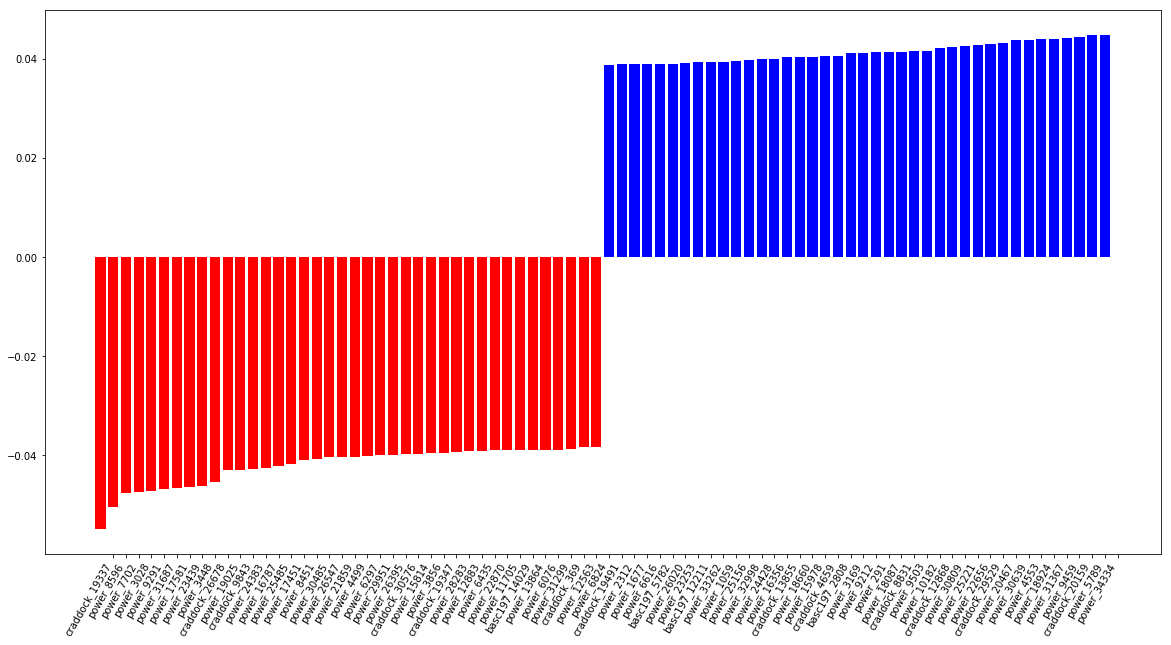

In [23]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [24]:
coef = log_reg.coef_.ravel()

coef.min(), coef.max(), np.abs(coef).min(), len(coef)

(-0.05487320705706374, 0.04481469133980149, 0.0002989386010697541, 6009)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


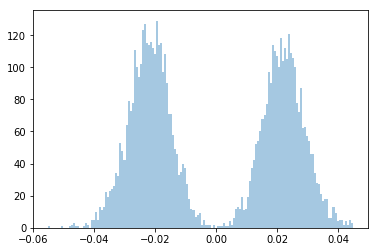

In [25]:
sns.distplot(coef, kde=False, bins=150)

In [26]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search



In [30]:
neg_thresholds = np.linspace(-0.015, -0.027, 12)
pos_thresholds = np.linspace(0.015, 0.027, 12)

In [31]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" | ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
    
    print("{} | ".format(len(top_1_selected_columns)), end=" -> ")
    results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.015 0.015 | 5134 |  -> 0.9993796549272054
Trial:  1 -0.015 0.01609090909090909 | 5021 |  -> 0.9994376660803173
Trial:  2 -0.015 0.01718181818181818 | 4893 |  -> 0.9994956772334295
Trial:  3 -0.015 0.018272727272727274 | 4732 |  -> 0.999470414311913
Trial:  4 -0.015 0.019363636363636364 | 4558 |  -> 0.9994676073206333
Trial:  5 -0.015 0.020454545454545454 | 4374 |  -> 0.9994432800628766
Trial:  6 -0.015 0.021545454545454545 | 4192 |  -> 0.9994685429843931
Trial:  7 -0.015 0.022636363636363635 | 4016 |  -> 0.9994077248400014
Trial:  8 -0.015 0.02372727272727273 | 3835 |  -> 0.9991569669523559
Trial:  9 -0.015 0.024818181818181816 | 3649 |  -> 0.998525393914443
Trial:  10 -0.015 0.02590909090909091 | 3480 |  -> 0.9977852838803848
Trial:  11 -0.015 0.027 | 3336 |  -> 0.996170328230847
Trial:  12 -0.01609090909090909 0.015 | 5007 |  -> 0.9994732213031925
Trial:  13 -0.01609090909090909 0.01609090909090909 | 4894 |  -> 0.9995106478535873
Trial:  14 -0.01609090909090909 0.0171818

In [32]:
# best_thresholds = (-0.0082, 0.0088)
# best_thresholds = (-0.011, 0.011)
best_thresholds

(-0.020454545454545454, 0.01718181818181818)

In [33]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.020454545454545454 0.01718181818181818
2252 1782 6009
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 1.000 +- 0.000 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.990 +- 0.005


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.3s finished


In [34]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["basc197_54", "basc197_85", "basc197_96", "basc197_97", "basc197_339", "basc197_452", "basc197_713", "basc197_748", "basc197_765", "basc197_770", "basc197_787", "basc197_791", "basc197_800", "basc197_806", "basc197_869", "basc197_893", "basc197_910", "basc197_948", "basc197_964", "basc197_967", "basc197_970", "basc197_1093", "basc197_1129", "basc197_1135", "basc197_1149", "basc197_1161", "basc197_1164", "basc197_1402", "basc197_1454", "basc197_1482", "basc197_1501", "basc197_1502", "basc197_1516", "basc197_1610", "basc197_1752", "basc197_1773", "basc197_1786", "basc197_1810", "basc197_1854", "basc197_1930", "basc197_1942", "basc197_1945", "basc197_1961", "basc197_2044", "basc197_2090", "basc197_2110", "basc197_2145", "basc197_2153", "basc197_2160", "basc197_2163", "basc197_2244", "basc197_2254", "basc197_2279", "basc197_2292", "basc197_2323", "basc197_2367", "basc197_2418", "basc197_2444", "basc197_2506", "basc197_2530", "basc197_2534", "basc197_2542", "basc197_2554", "basc197_2559", 

, "basc197_18189", "basc197_18242", "basc197_18285", "basc197_18290", "basc197_18307", "basc197_18332", "basc197_18334", "basc197_18470", "basc197_18515", "basc197_18800", "basc197_18847", "basc197_18851", "basc197_18870", "basc197_19110", "basc197_19162", "basc197_19165", "basc197_19188", "basc197_19229", "basc197_19275", "craddock_9", "craddock_96", "craddock_175", "craddock_184", "craddock_248", "craddock_355", "craddock_371", "craddock_388", "craddock_428", "craddock_480", "craddock_482", "craddock_514", "craddock_515", "craddock_578", "craddock_618", "craddock_668", "craddock_669", "craddock_693", "craddock_721", "craddock_747", "craddock_759", "craddock_800", "craddock_837", "craddock_872", "craddock_900", "craddock_910", "craddock_926", "craddock_959", "craddock_1027", "craddock_1039", "craddock_1070", "craddock_1145", "craddock_1165", "craddock_1193", "craddock_1235", "craddock_1250", "craddock_1364", "craddock_1409", "craddock_1517", "craddock_1585", "craddock_1626", "craddock

In [41]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = another_evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.020454545454545454 0.01718181818181818
2252 1782 6009
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 1.000 +- 0.000 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.998 +- 0.002


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished


Evaluation on reduced `top_1_selected_columns`:

In [60]:
reduced_top_1_selected_columns = np.random.choice(top_1_selected_columns, size=1500).tolist()

In [61]:
results = evaluation(data2_train.loc[:, reduced_top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.980 +- 0.005 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.934 +- 0.009


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished


BASC197 connectome only:

In [45]:

results = evaluation(data2_train.loc[:, power_features], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.724 +- 0.014 

Training score accuracy: 0.998 +- 0.004
Validation score accuracy: 0.667 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


Group features

In [73]:
g1 = sorted([c for c in top_1_selected_columns if 'x participants_age' in c])
g2 = sorted([c for c in top_1_selected_columns if '/ participants_age' in c])

In [93]:
data2_train[g2].head()

,power_1011 / participants_age,power_10121 / participants_age,power_10132 / participants_age,power_10157 / participants_age,power_10182 / participants_age,power_10189 / participants_age,power_10220 / participants_age,power_10222 / participants_age,power_10251 / participants_age,power_1027 / participants_age,...,power_9711 / participants_age,power_9791 / participants_age,power_9808 / participants_age,power_9812 / participants_age,power_9829 / participants_age,power_9887 / participants_age,power_9947 / participants_age,power_9973 / participants_age,power_9976 / participants_age,power_9977 / participants_age
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,0.001872,-0.005945,0.001816,-0.012165,-0.012887,0.001702,-0.040141,-0.014127,-0.026481,0.003697,...,0.002252,0.002940,-0.031543,0.001574,-0.024191,-0.010987,-0.027573,-0.002274,-0.000633,-0.004441
5174041730092253771,-0.001247,-0.000069,0.004723,-0.006227,0.002403,-0.002101,0.009169,-0.007831,-0.011127,0.004001,...,-0.012233,0.007656,-0.011082,-0.004211,-0.013868,-0.000736,0.006704,-0.012615,-0.010779,-0.013103
10219322676643534800,0.006286,0.001422,-0.001094,-0.000208,-0.001770,0.000936,0.004261,0.001300,-0.007462,0.006625,...,-0.000445,-0.004848,0.004789,0.001523,0.001417,-0.004481,-0.006100,-0.004436,0.001066,0.001631
10645466564919190227,-0.007225,0.012837,0.018158,-0.004738,-0.007177,0.019192,0.025324,0.014880,0.016702,-0.014136,...,-0.002778,-0.014727,0.001053,0.011736,0.023471,0.000433,0.022908,-0.005422,-0.007200,-0.013952
14512541342641936232,-0.010753,-0.001597,-0.008679,-0.004177,0.022726,-0.005658,-0.009915,-0.018629,-0.012611,0.027206,...,0.005555,-0.026349,-0.013828,0.000454,-0.010105,-0.003084,0.010799,0.009075,0.002914,0.005974


In [94]:
data2_train.loc[:, 'g1'] = data2_train[g1].abs().sum(axis=1)
data2_train.loc[:, 'g2'] = data2_train[g2].abs().sum(axis=1)

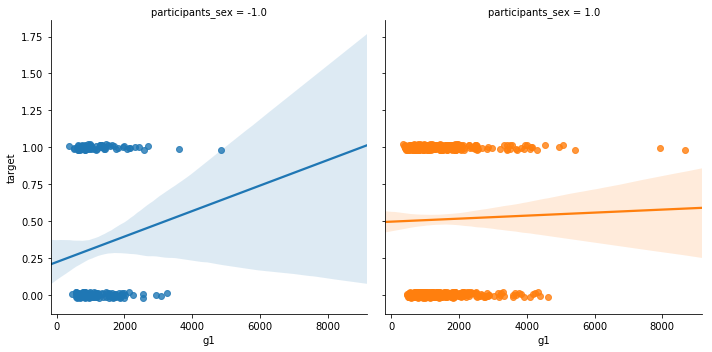

In [95]:
g = sns.lmplot(x="g1", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

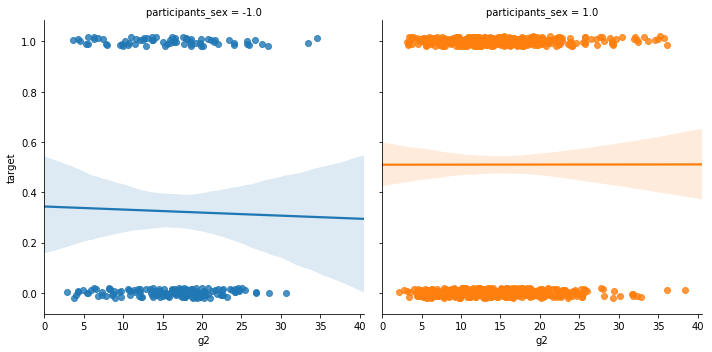

In [96]:
g = sns.lmplot(x="g2", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

In [98]:
results = evaluation(data2_train.loc[:, g1], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.987 +- 0.006
Validation score ROC-AUC: 0.924 +- 0.012 

Training score accuracy: 0.939 +- 0.023
Validation score accuracy: 0.837 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


In [99]:
results = evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.999 +- 0.001
Validation score ROC-AUC: 0.963 +- 0.011 

Training score accuracy: 0.981 +- 0.012
Validation score accuracy: 0.890 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished


In [100]:
results = original_evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.998 +- 0.000
Validation score ROC-AUC: 0.976 +- 0.006 

Training score accuracy: 0.976 +- 0.003
Validation score accuracy: 0.912 +- 0.010


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s finished


In [101]:
print("[", end="")
for f in g2:
    print("\"{}\"".format(f), end=", ")
print("]")

["power_1011 / participants_age", "power_10121 / participants_age", "power_10132 / participants_age", "power_10157 / participants_age", "power_10182 / participants_age", "power_10189 / participants_age", "power_10220 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_1027 / participants_age", "power_1028 / participants_age", "power_10375 / participants_age", "power_1043 / participants_age", "power_10444 / participants_age", "power_1045 / participants_age", "power_10457 / participants_age", "power_10463 / participants_age", "power_10515 / participants_age", "power_10589 / participants_age", "power_10654 / participants_age", "power_10660 / participants_age", "power_10717 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_1075 / participants_age", "power_10880 / participants_age", "power_10882 / participants_age", "power_1094 / participants_age", "power_10951 / participants_age", "power_10953 / parti

PCA on covariance vector connectome

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
pca_x_train = pca.transform(x_train)

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        self.pca = PCA(n_components=70)
        
    def fit(self, X_df, y):
        self.pca.fit(X_df)
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return self.pca.transform(X_df)
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [56]:
results = evaluation(x_train, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.824 +- 0.018
Validation score ROC-AUC: 0.697 +- 0.013 

Training score accuracy: 0.746 +- 0.019
Validation score accuracy: 0.639 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


PCA 90
```
Training score ROC-AUC: 0.853 +- 0.012
Validation score ROC-AUC: 0.703 +- 0.015 

Training score accuracy: 0.777 +- 0.012
Validation score accuracy: 0.648 +- 0.011
```



PCA on vector tangent connectome

In [69]:
# Precompute features
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


fmri_motions_filenames = data1_train['fmri_motions']        
fmri_power_filenames = data1_train['fmri_power_2011']

all_confounds = [np.loadtxt(os.path.join(path, path_motions)) 
                 for path_motions in fmri_motions_filenames]

all_timeseries = [pd.read_csv(os.path.join(path, subject_filename), header=None).values 
                  for subject_filename in fmri_power_filenames]

all_cleaned_timeseries = [clean(ts, confounds=cf) for ts, cf in zip(all_timeseries, all_confounds)]
all_cleaned_timeseries = np.array(all_cleaned_timeseries)

In [70]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # make a transformer which will load the time series and compute the connectome matrix
        self.transformer_fmri = make_pipeline(
            ConnectivityMeasure(kind='tangent', vectorize=True),
            PCA(n_components=100)
        )
        
    def fit(self, X_df, y):
        self.transformer_fmri.fit(X_df)
        return self

    def transform(self, X_df):
        return self.transformer_fmri.transform(X_df)
    
    
class Classifier(BaseEstimator):
    
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)    

In [71]:
results = evaluation(all_cleaned_timeseries, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.844 +- 0.012
Validation score ROC-AUC: 0.689 +- 0.025 

Training score accuracy: 0.753 +- 0.016
Validation score accuracy: 0.633 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.5min finished
